In [1]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

### Data Agumentation and Normalization

In [27]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(128),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [28]:
### Load Datasets

In [29]:
train_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=4)

print("Number of training images: ",len(train_dataset))
print("Number of testing images: ",len(valid_dataset))

Number of training images:  70295
Number of testing images:  17572


In [6]:
### Define CNN Model

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

         # Calculate the correct number of features
        self._to_linear = None
        self._get_features_shape()
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(self._to_linear, 1500),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1500, 38)
        )
    def _get_features_shape(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 128, 128)
            x = self.features(x)
            self._to_linear = x.numel()

    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [8]:
# Check GPU availability
device_count = torch.cuda.device_count()
print(f"Number of GPUs available: {device_count}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Number of GPUs available: 1
Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN().to(device)

In [10]:
# Print model summary
def print_model_summary(model):
    print("Model Summary:")
    print("--------------------")
    for name, module in model.named_children():
        print(f"Layer: {name}")
        print(module)
        print("--------------------")

    print("Total Parameters:")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params}")

print_model_summary(model)

Model Summary:
--------------------
Layer: features
Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (18): ReLU()
  (19): MaxPool2d(kernel_size=2, stride=2, 

In [11]:
#Training

In [12]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=3):
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0
        
        # Training loop with tqdm progress bar
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False) as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)
                total += labels.size(0)
                
                # Update progress bar description
                tepoch.set_postfix(train_loss=running_loss / total, train_acc=corrects.double() / total)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = corrects.double() / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        model.eval()
        running_loss = 0.0
        corrects = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                corrects += torch.sum(preds == labels.data)
                total += labels.size(0)
        
        valid_loss = running_loss / len(valid_loader.dataset)
        valid_acc = corrects.double() / total
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

        
        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'train_acc: {train_acc:.4f}, '
              f'train_loss: {train_loss:.4f}, '
              f'valid_loss: {valid_loss:.4f}, '
              f'valid_acc: {valid_acc:.4f}')
  
    
    return history




# # Training
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)

# def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=1):
#     history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         corrects = 0
#         total = 0
        
#         with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False) as tepoch:
#             for images, labels in tepoch:
#                 images, labels = images.to(device), labels.to(device)
#                 optimizer.zero_grad()
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
                
#                 running_loss += loss.item() * images.size(0)
#                 _, preds = torch.max(outputs, 1)
#                 corrects += torch.sum(preds == labels.data)
#                 total += labels.size(0)
                
#                 tepoch.set_postfix(train_loss=running_loss / total, train_acc=corrects.double() / total)
        
#         train_loss = running_loss / len(train_loader.dataset)
#         train_acc = corrects.double() / total
#         history['train_loss'].append(train_loss)
#         history['train_acc'].append(train_acc)
        
#         model.eval()
#         running_loss = 0.0
#         corrects = 0
#         total = 0
        
#         with torch.no_grad():
#             for images, labels in valid_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
                
#                 running_loss += loss.item() * images.size(0)
#                 _, preds = torch.max(outputs, 1)
#                 corrects += torch.sum(preds == labels.data)
#                 total += labels.size(0)
        
#         valid_loss = running_loss / len(valid_loader.dataset)
#         valid_acc = corrects.double() / total
#         history['valid_loss'].append(valid_loss)
#         history['valid_acc'].append(valid_acc)
        
#         print(f'Epoch [{epoch+1}/{num_epochs}], '
#               f'train_acc: {train_acc:.4f}, '
#               f'train_loss: {train_loss:.4f}, '
#               f'valid_loss: {valid_loss:.4f}, '
#               f'valid_acc: {valid_acc:.4f}')
    
#     return history

In [13]:
history = train_model(model, train_loader, valid_loader, criterion, optimizer)

Epoch [1/3], train_acc: 0.1294, train_loss: 3.1737, valid_loss: 2.5748, valid_acc: 0.2656


Epoch [2/3], train_acc: 0.3413, train_loss: 2.2668, valid_loss: 1.8801, valid_acc: 0.4443


Epoch [3/3], train_acc: 0.4676, train_loss: 1.7824, valid_loss: 1.6308, valid_acc: 0.5095


In [14]:
# Save the model
torch.save(model.state_dict(), 'basic_cnn.pth')
print("Model saved as model.pth")

Model saved as model.pth


### Plotting Results

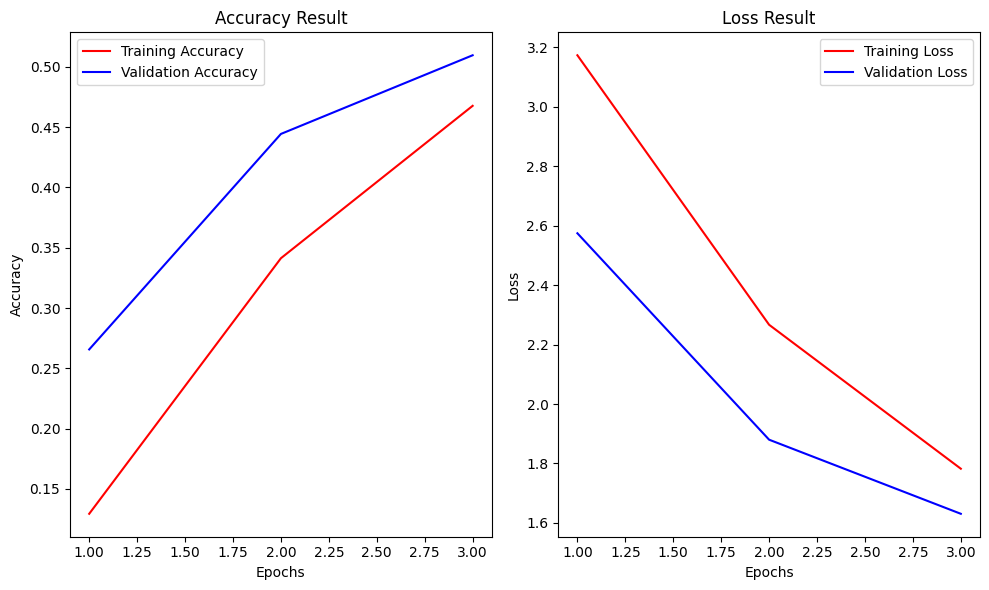

In [15]:
    # Plotting results
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(10, 6))

    # Convert accuracy tensors to numpy arrays
    train_acc_np = [acc.cpu().numpy() for acc in history['train_acc']]
    valid_acc_np = [acc.cpu().numpy() for acc in history['valid_acc']]
    # Directly use float values for loss
    train_loss_np = history['train_loss']
    valid_loss_np = history['valid_loss']

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_np, 'r', label='Training Accuracy')
    plt.plot(epochs, valid_acc_np, 'b', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Result')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_np, 'r', label='Training Loss')
    plt.plot(epochs, valid_loss_np, 'b', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Result')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [16]:
# # Model evaluation
# def evaluate_model(model, data_loader):
#     model.eval()
#     y_true = []
#     y_pred = []
#     y_score = []  # To store probabilities for ROC
    
#     with torch.no_grad():
#         for images, labels in data_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             probs = nn.Softmax(dim=1)(outputs)  # Get probabilities
#             _, preds = torch.max(outputs, 1)
            
#             y_true.extend(labels.cpu().numpy())
#             y_pred.extend(preds.cpu().numpy())
#             y_score.extend(probs.cpu().numpy())
    
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)
#     y_score = np.array(y_score)
    
#     # Binarize the labels for ROC curve calculation
#     y_true_bin = label_binarize(y_true, classes=np.arange(38))
#     return y_true_bin, y_pred, y_score

# Evaluation on training set
# def evaluate(model, data_loader):
#     model.eval()
#     running_loss = 0.0
#     corrects = 0
#     total = 0
    
#     with torch.no_grad():
#         for images, labels in data_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
            
#             running_loss += loss.item() * images.size(0)
#             _, preds = torch.max(outputs, 1)
#             corrects += torch.sum(preds == labels.data)
#             total += labels.size(0)
    
#     avg_loss = running_loss / len(data_loader.dataset)
#     accuracy = corrects.double() / total
#     return avg_loss, accuracy

# train_loss, train_acc = evaluate(model, train_loader)
# print(f'Training Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}')

# valid_loss, valid_acc = evaluate(model, valid_loader)
# print(f'Validation Loss: {valid_loss:.4f} Accuracy: {valid_acc:.4f}')


# from sklearn.metrics import classification_report

def evaluate(model, data_loader):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            
            # Collect all labels and predictions for classification report
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = corrects.double() / total
    
    return avg_loss, accuracy, all_labels, all_preds

# Evaluate on the training set
train_loss, train_acc, train_labels, train_preds = evaluate(model, train_loader)
print(f'Training Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}')

# Evaluate on the validation set
valid_loss, valid_acc, valid_labels, valid_preds = evaluate(model, valid_loader)
print(f'Validation Loss: {valid_loss:.4f} Accuracy: {valid_acc:.4f}')

Training Loss: 1.6124 Accuracy: 0.5120
Validation Loss: 1.6353 Accuracy: 0.5120


In [17]:
# Generate classification report for training set
class_names = train_dataset.classes
print("Training Set Classification Report:")
print(classification_report(train_labels, train_preds, target_names=class_names))

Training Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.26      0.44      0.33      2016
                                 Apple___Black_rot       0.49      0.28      0.35      1987
                          Apple___Cedar_apple_rust       0.39      0.61      0.47      1760
                                   Apple___healthy       0.59      0.48      0.53      2008
                               Blueberry___healthy       0.48      0.64      0.55      1816
          Cherry_(including_sour)___Powdery_mildew       0.60      0.71      0.65      1683
                 Cherry_(including_sour)___healthy       0.65      0.70      0.67      1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.46      0.44      0.45      1642
                       Corn_(maize)___Common_rust_       0.78      0.77      0.77      1907
               Corn_(maize)___Northern_Leaf

In [18]:
# Generate classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(valid_labels, valid_preds, target_names=class_names))

# # Generate classification report for validation set
# class_names = train_dataset.classes
# print("Validation Set Classification Report:")
# print(classification_report(valid_labels, valid_preds, target_names=class_names))

Validation Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.25      0.43      0.32       504
                                 Apple___Black_rot       0.44      0.27      0.34       497
                          Apple___Cedar_apple_rust       0.37      0.56      0.45       440
                                   Apple___healthy       0.60      0.48      0.53       502
                               Blueberry___healthy       0.50      0.67      0.57       454
          Cherry_(including_sour)___Powdery_mildew       0.58      0.65      0.61       421
                 Cherry_(including_sour)___healthy       0.66      0.75      0.70       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.47      0.43      0.45       410
                       Corn_(maize)___Common_rust_       0.79      0.78      0.78       477
               Corn_(maize)___Northern_Le

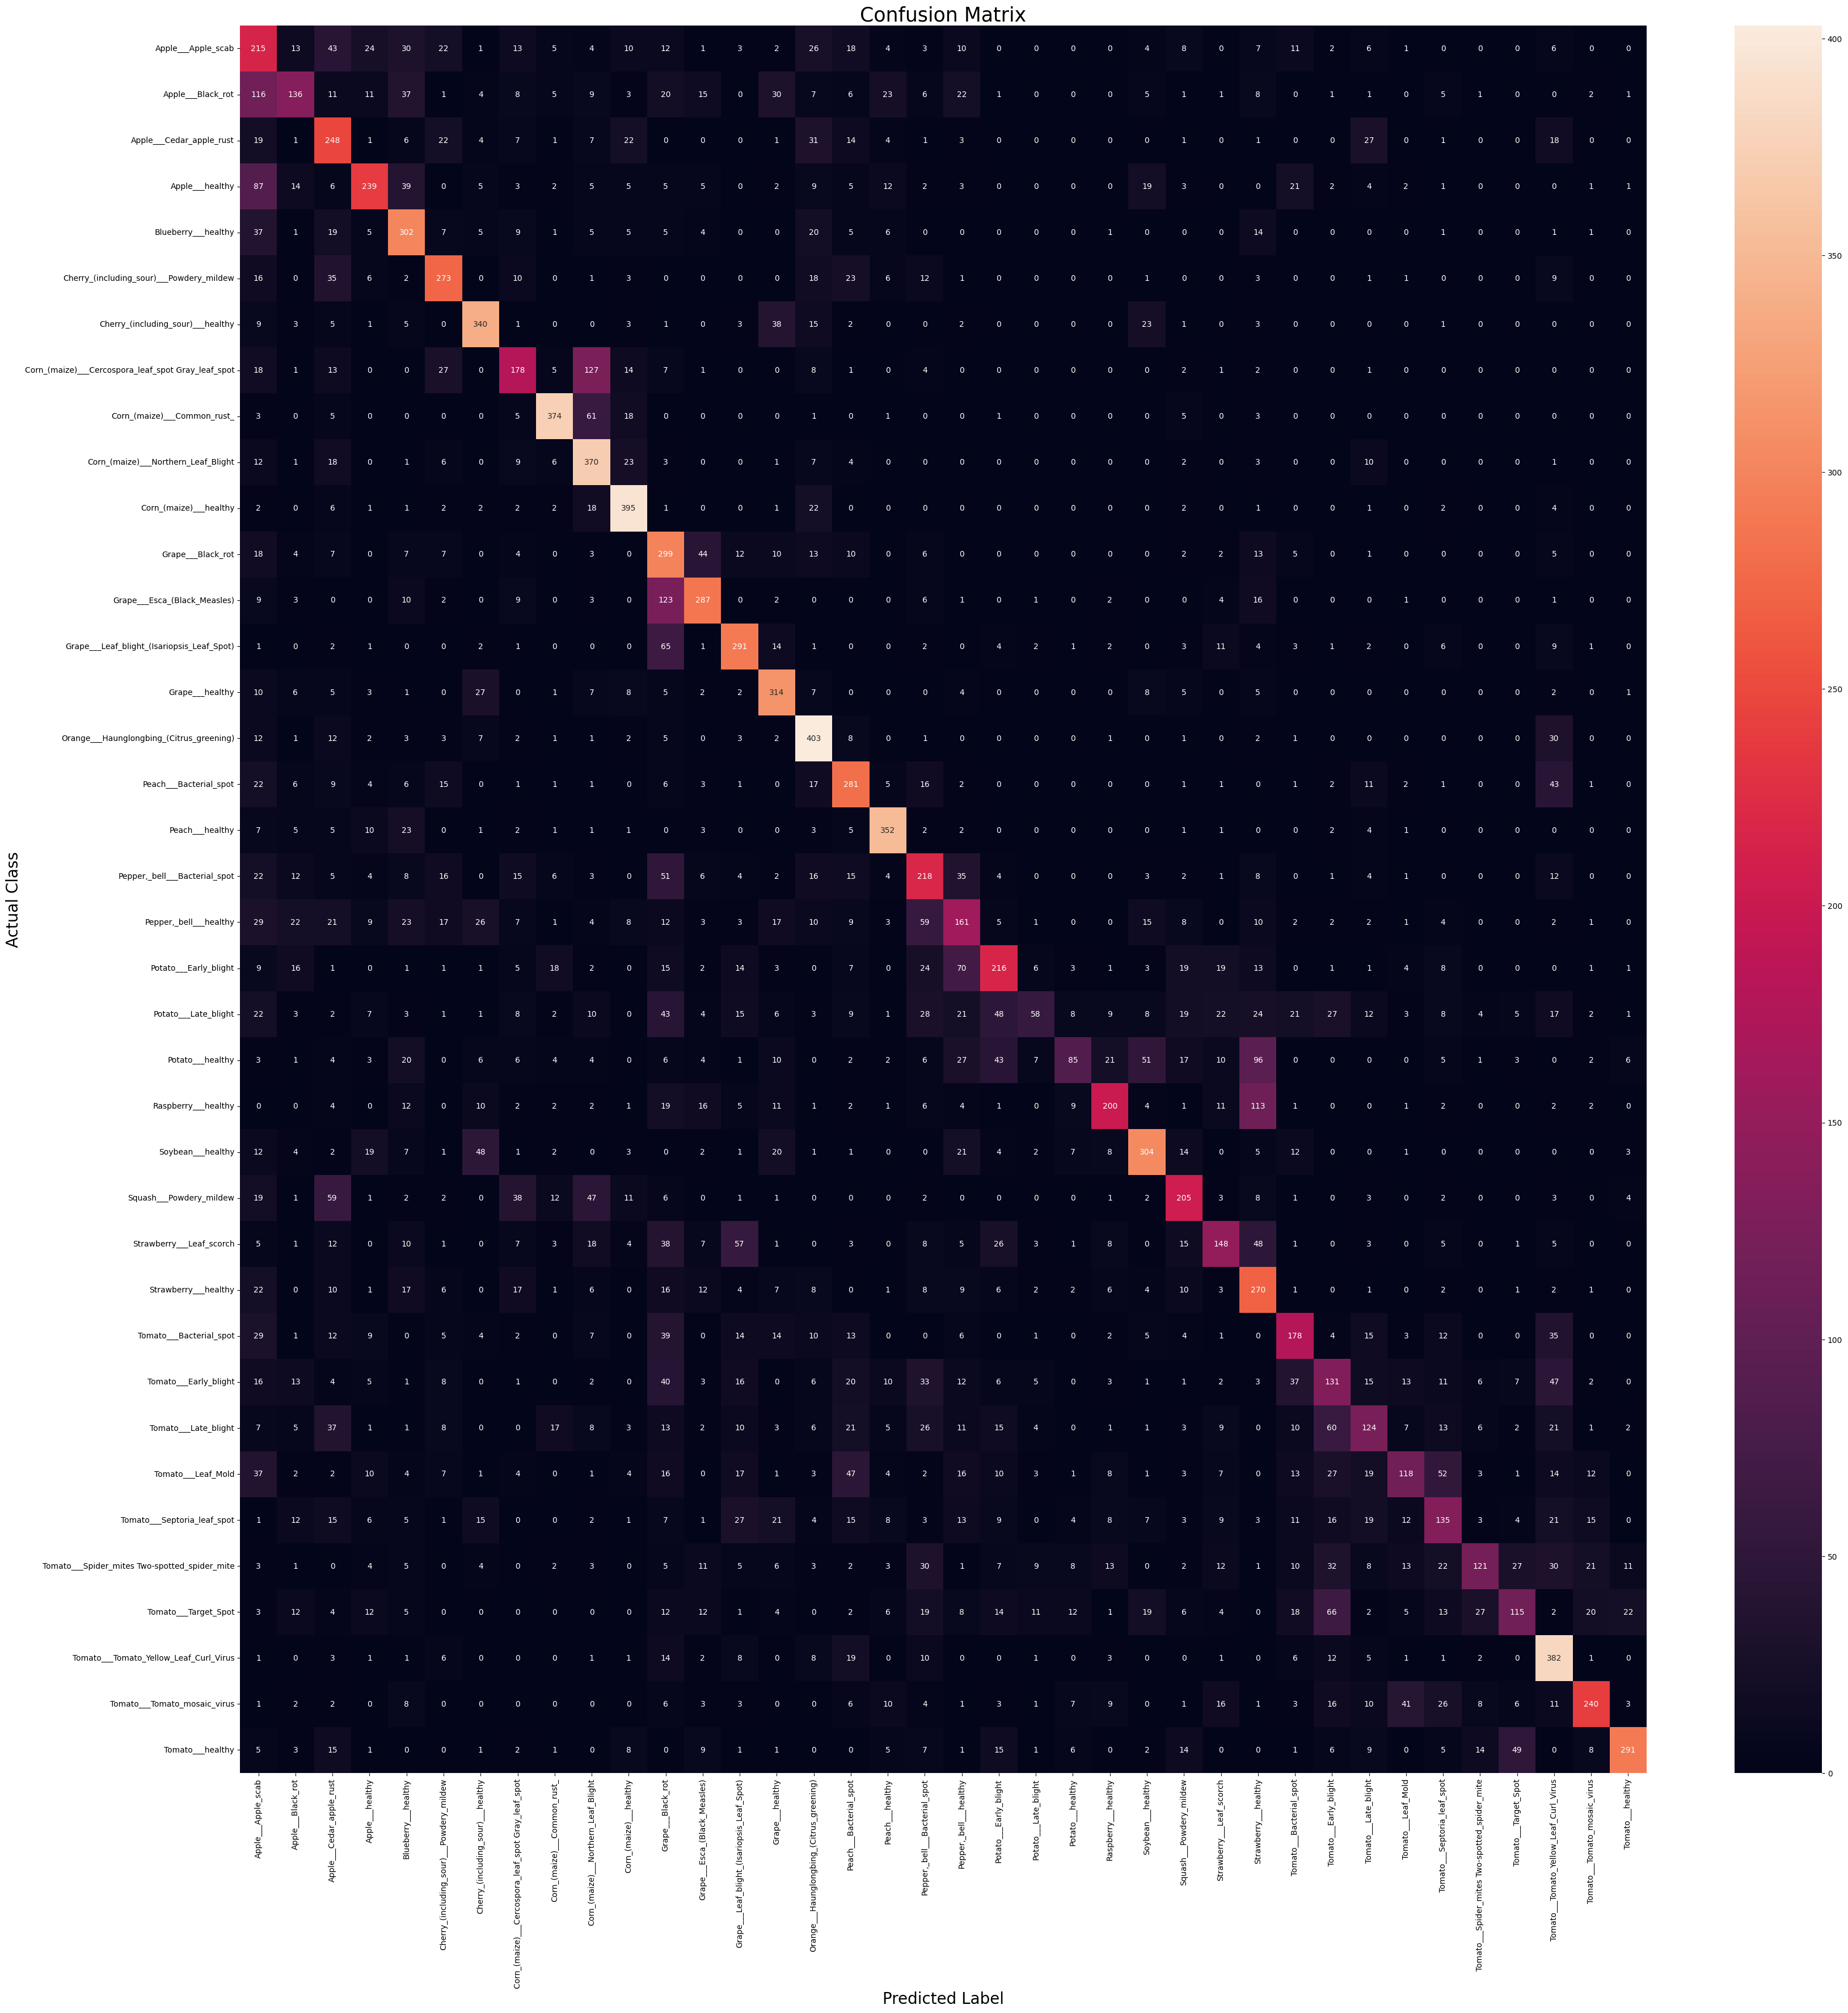

In [19]:
# Generate confusion matrix
cm = confusion_matrix(valid_labels, valid_preds, labels=range(len(class_names)))
plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 10}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.show()

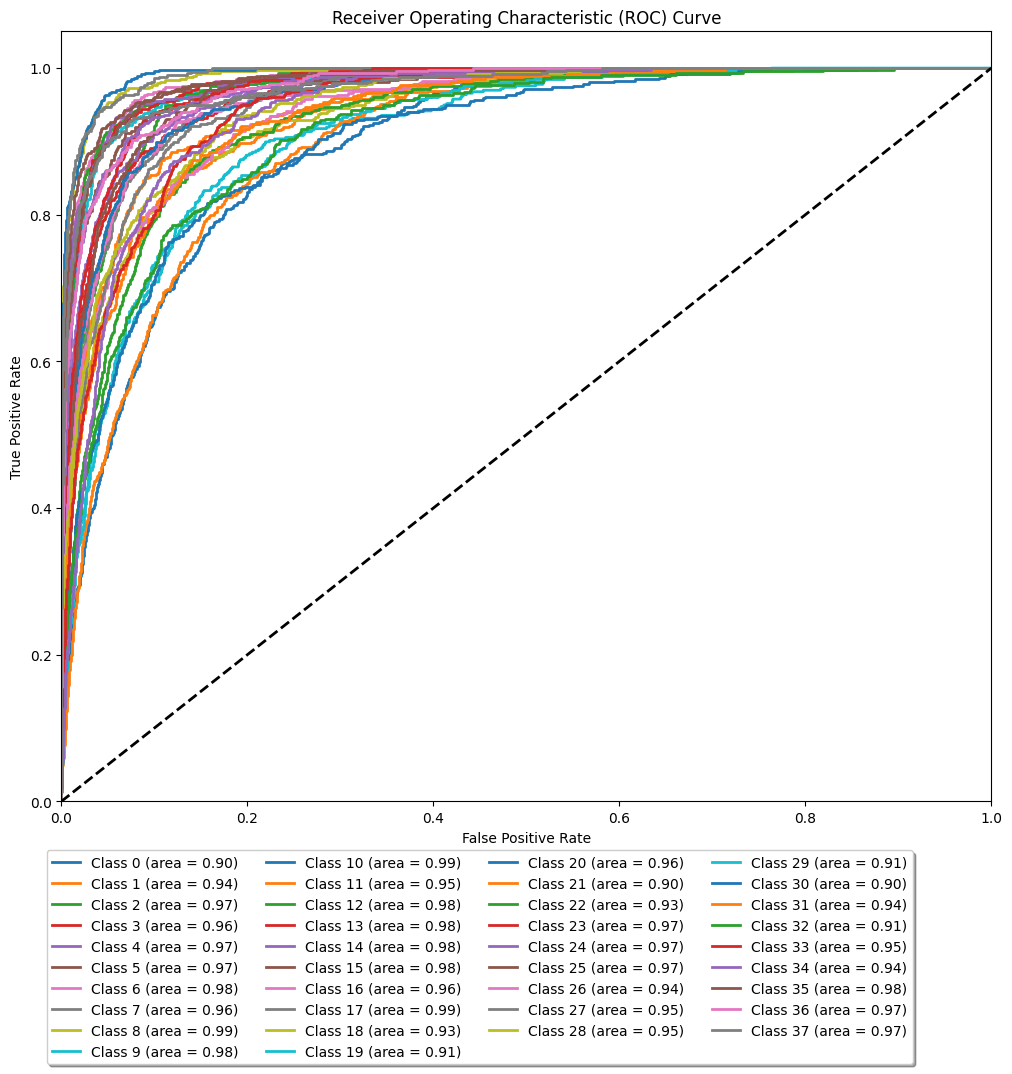

In [23]:

def plot_roc_curves(model, data_loader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities
            probs = torch.softmax(outputs, dim=1)
            
            # Collect all labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
    
    # Binarize the labels
    all_labels_bin = label_binarize(all_labels, classes=range(num_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], [p[i] for p in all_preds])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 10))
    
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    # plt.legend(loc='lower center')
    plt.legend(loc='lower center', bbox_to_anchor=(0.45, -0.35), fancybox=True, shadow=True, ncol=4)
    plt.show()

# Call the function for ROC curves
plot_roc_curves(model, valid_loader, num_classes=38)

In [20]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize
# from itertools import cycle
# import numpy as np

# def plot_roc_curve(y_true_bin, y_score, class_names):
#     # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
#     n_classes = len(class_names)

#     for i in range(n_classes):
#         fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

#     # Plot all ROC curves
#     plt.figure(figsize=(14, 4))
#     colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkred', 'green', 'purple', 'yellow', 'brown', 'pink', 'blue'])
#     for i, color in zip(range(n_classes), colors):
#         plt.plot(fpr[i], tpr[i], color=color, lw=2,
#                  label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

#     plt.plot([0, 1], [0, 1], 'k--', lw=2)
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curves')
    
#     # Place legend at the bottom with extra space
#     plt.legend(loc='lower center', bbox_to_anchor=(0.45, -0.35), fancybox=True, shadow=True, ncol=4)

#     plt.tight_layout(pad=-18.0)
#     plt.show()

# # Evaluate on validation dataset and plot the ROC curve
# y_true_bin, y_pred, y_score = evaluate_model(model, valid_loader)
# plot_roc_curve(y_true_bin, y_score, train_dataset.classes)

In [21]:
# class_names = train_dataset.classes
# print(classification_report(y_true, y_pred, target_names=class_names))

In [22]:
# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(40, 40))
# sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 10}, xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted Class', fontsize=20)
# plt.ylabel('Actual Class', fontsize=20)
# plt.title('Plant Disease Prediction Confusion Matrix', fontsize=25)
# plt.show()

# Transfer Learning Implementation

### Inception ModelV3

In [90]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [100]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

In [102]:
# List available GPUs and their memory usage
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)}")
    print(f"  Memory Cached: {torch.cuda.memory_reserved(i)}")

GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU
  Memory Allocated: 30235136
  Memory Cached: 13488881664


In [103]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [105]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(299),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = torchvision.datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/train', transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/valid', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

print("Number of training images: ", len(train_dataset))
print("Number of validation images: ", len(valid_dataset))

Number of training images:  70295
Number of validation images:  17572


In [106]:
# Print model summary
def print_model_summary(model):
    print("Model Summary:")
    print("--------------------")
    for name, module in model.named_children():
        print(f"Layer: {name}")
        print(module)
        print("--------------------")

    print("Total Parameters:")
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {total_params}")

print_model_summary(model)

Model Summary:
--------------------
Layer: Conv2d_1a_3x3
BasicConv2d(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
--------------------
Layer: Conv2d_2a_3x3
BasicConv2d(
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
--------------------
Layer: Conv2d_2b_3x3
BasicConv2d(
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
)
--------------------
Layer: maxpool1
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
--------------------
Layer: Conv2d_3b_1x1
BasicConv2d(
  (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stat

In [111]:
# Define the InceptionV3 model
model = models.inception_v3(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))

In [112]:
# Wrap model with DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [119]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Gradient accumulation settings
accumulation_steps = 4

# Train the model
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=1):
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Get the main output
            
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss = loss / accumulation_steps  # Scale loss for gradient accumulation
            loss.backward()
            
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            # Statistics
            running_loss += loss.item() * accumulation_steps
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]  # Get the main output
                
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(valid_loader)
        val_acc = val_correct / val_total
        
        # Print the full summary for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"train_acc: {epoch_acc:.4f}, train_loss: {epoch_loss:.4f}, "
              f"valid_loss: {val_loss:.4f}, valid_acc: {val_acc:.4f}")

    return history


In [120]:
# import torch
# torch.cuda.empty_cache()

In [121]:
# Train the model
history = train_model(model, train_loader, valid_loader, criterion, optimizer)

Epoch 1/1: 100%|███████████████████████████████████████████████████████████████████| 4394/4394 [11:39<00:00,  6.28it/s]


Epoch [1/1], train_acc: 0.9429, train_loss: 0.1881, valid_loss: 0.1157, valid_acc: 0.9619


In [122]:
# Save the model
torch.save(model.state_dict(), 'inception_v3.pth')
print("Model saved as inception_v3.pth")

Model saved as inception_v3.pth


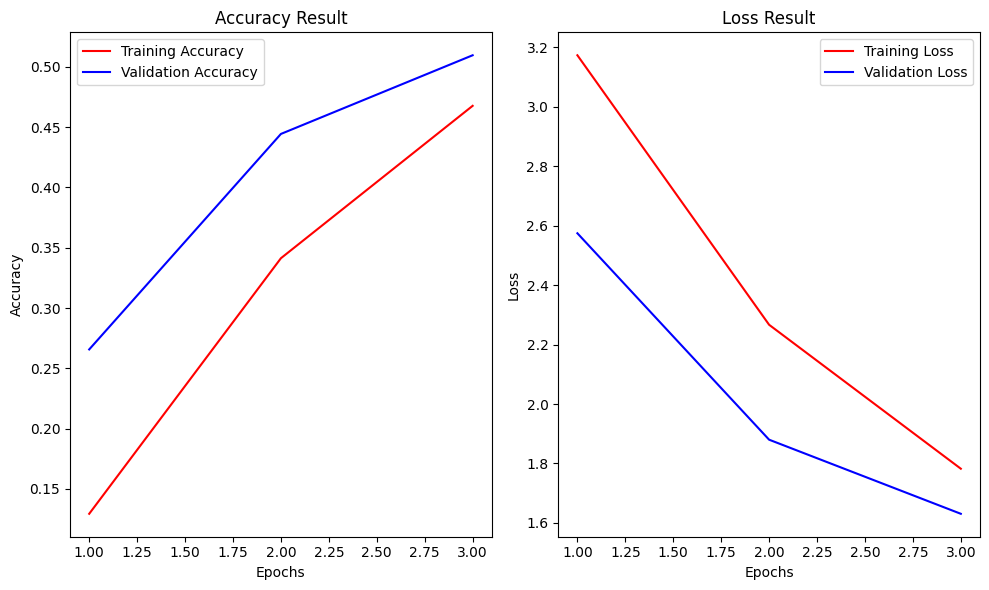

In [123]:
# Plotting results
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(10, 6))

# Convert accuracy tensors to numpy arrays
train_acc_np = [acc.cpu().numpy() for acc in history['train_acc']]
valid_acc_np = [acc.cpu().numpy() for acc in history['valid_acc']]
# Directly use float values for loss
train_loss_np = history['train_loss']
valid_loss_np = history['valid_loss']

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc_np, 'r', label='Training Accuracy')
plt.plot(epochs, valid_acc_np, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Result')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss_np, 'r', label='Training Loss')
plt.plot(epochs, valid_loss_np, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Result')
plt.legend()

plt.tight_layout()
plt.show()

In [125]:
# Evaluate the model
def evaluate(model, data_loader):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            
            # Collect all labels and predictions for classification report
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = corrects.double() / total
    
    return avg_loss, accuracy, all_labels, all_preds

# Evaluate on the training set
train_loss, train_acc, train_labels, train_preds = evaluate(model, train_loader)
print(f'Training Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}')

# Evaluate on the validation set
valid_loss, valid_acc, valid_labels, valid_preds = evaluate(model, valid_loader)
print(f'Validation Loss: {valid_loss:.4f} Accuracy: {valid_acc:.4f}')

Training Loss: 0.1013 Accuracy: 0.9681
Validation Loss: 0.1150 Accuracy: 0.9626


In [126]:
# Generate classification report for training set
class_names = train_dataset.classes
print("Training Set Classification Report:")
print(classification_report(train_labels, train_preds, target_names=class_names))


Training Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.98      0.98      2016
                                 Apple___Black_rot       0.97      0.99      0.98      1987
                          Apple___Cedar_apple_rust       0.99      0.98      0.99      1760
                                   Apple___healthy       0.99      0.96      0.97      2008
                               Blueberry___healthy       0.99      0.98      0.98      1816
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99      1683
                 Cherry_(including_sour)___healthy       0.99      0.99      0.99      1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.96      0.93      1642
                       Corn_(maize)___Common_rust_       0.98      0.98      0.98      1907
               Corn_(maize)___Northern_Leaf

In [127]:
# Generate classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(valid_labels, valid_preds, target_names=class_names))


Validation Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.98      0.98       504
                                 Apple___Black_rot       0.97      0.98      0.98       497
                          Apple___Cedar_apple_rust       0.99      0.98      0.98       440
                                   Apple___healthy       0.99      0.95      0.97       502
                               Blueberry___healthy       0.97      0.98      0.98       454
          Cherry_(including_sour)___Powdery_mildew       0.98      0.99      0.99       421
                 Cherry_(including_sour)___healthy       0.97      0.99      0.98       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.86      0.95      0.90       410
                       Corn_(maize)___Common_rust_       0.98      0.98      0.98       477
               Corn_(maize)___Northern_Le

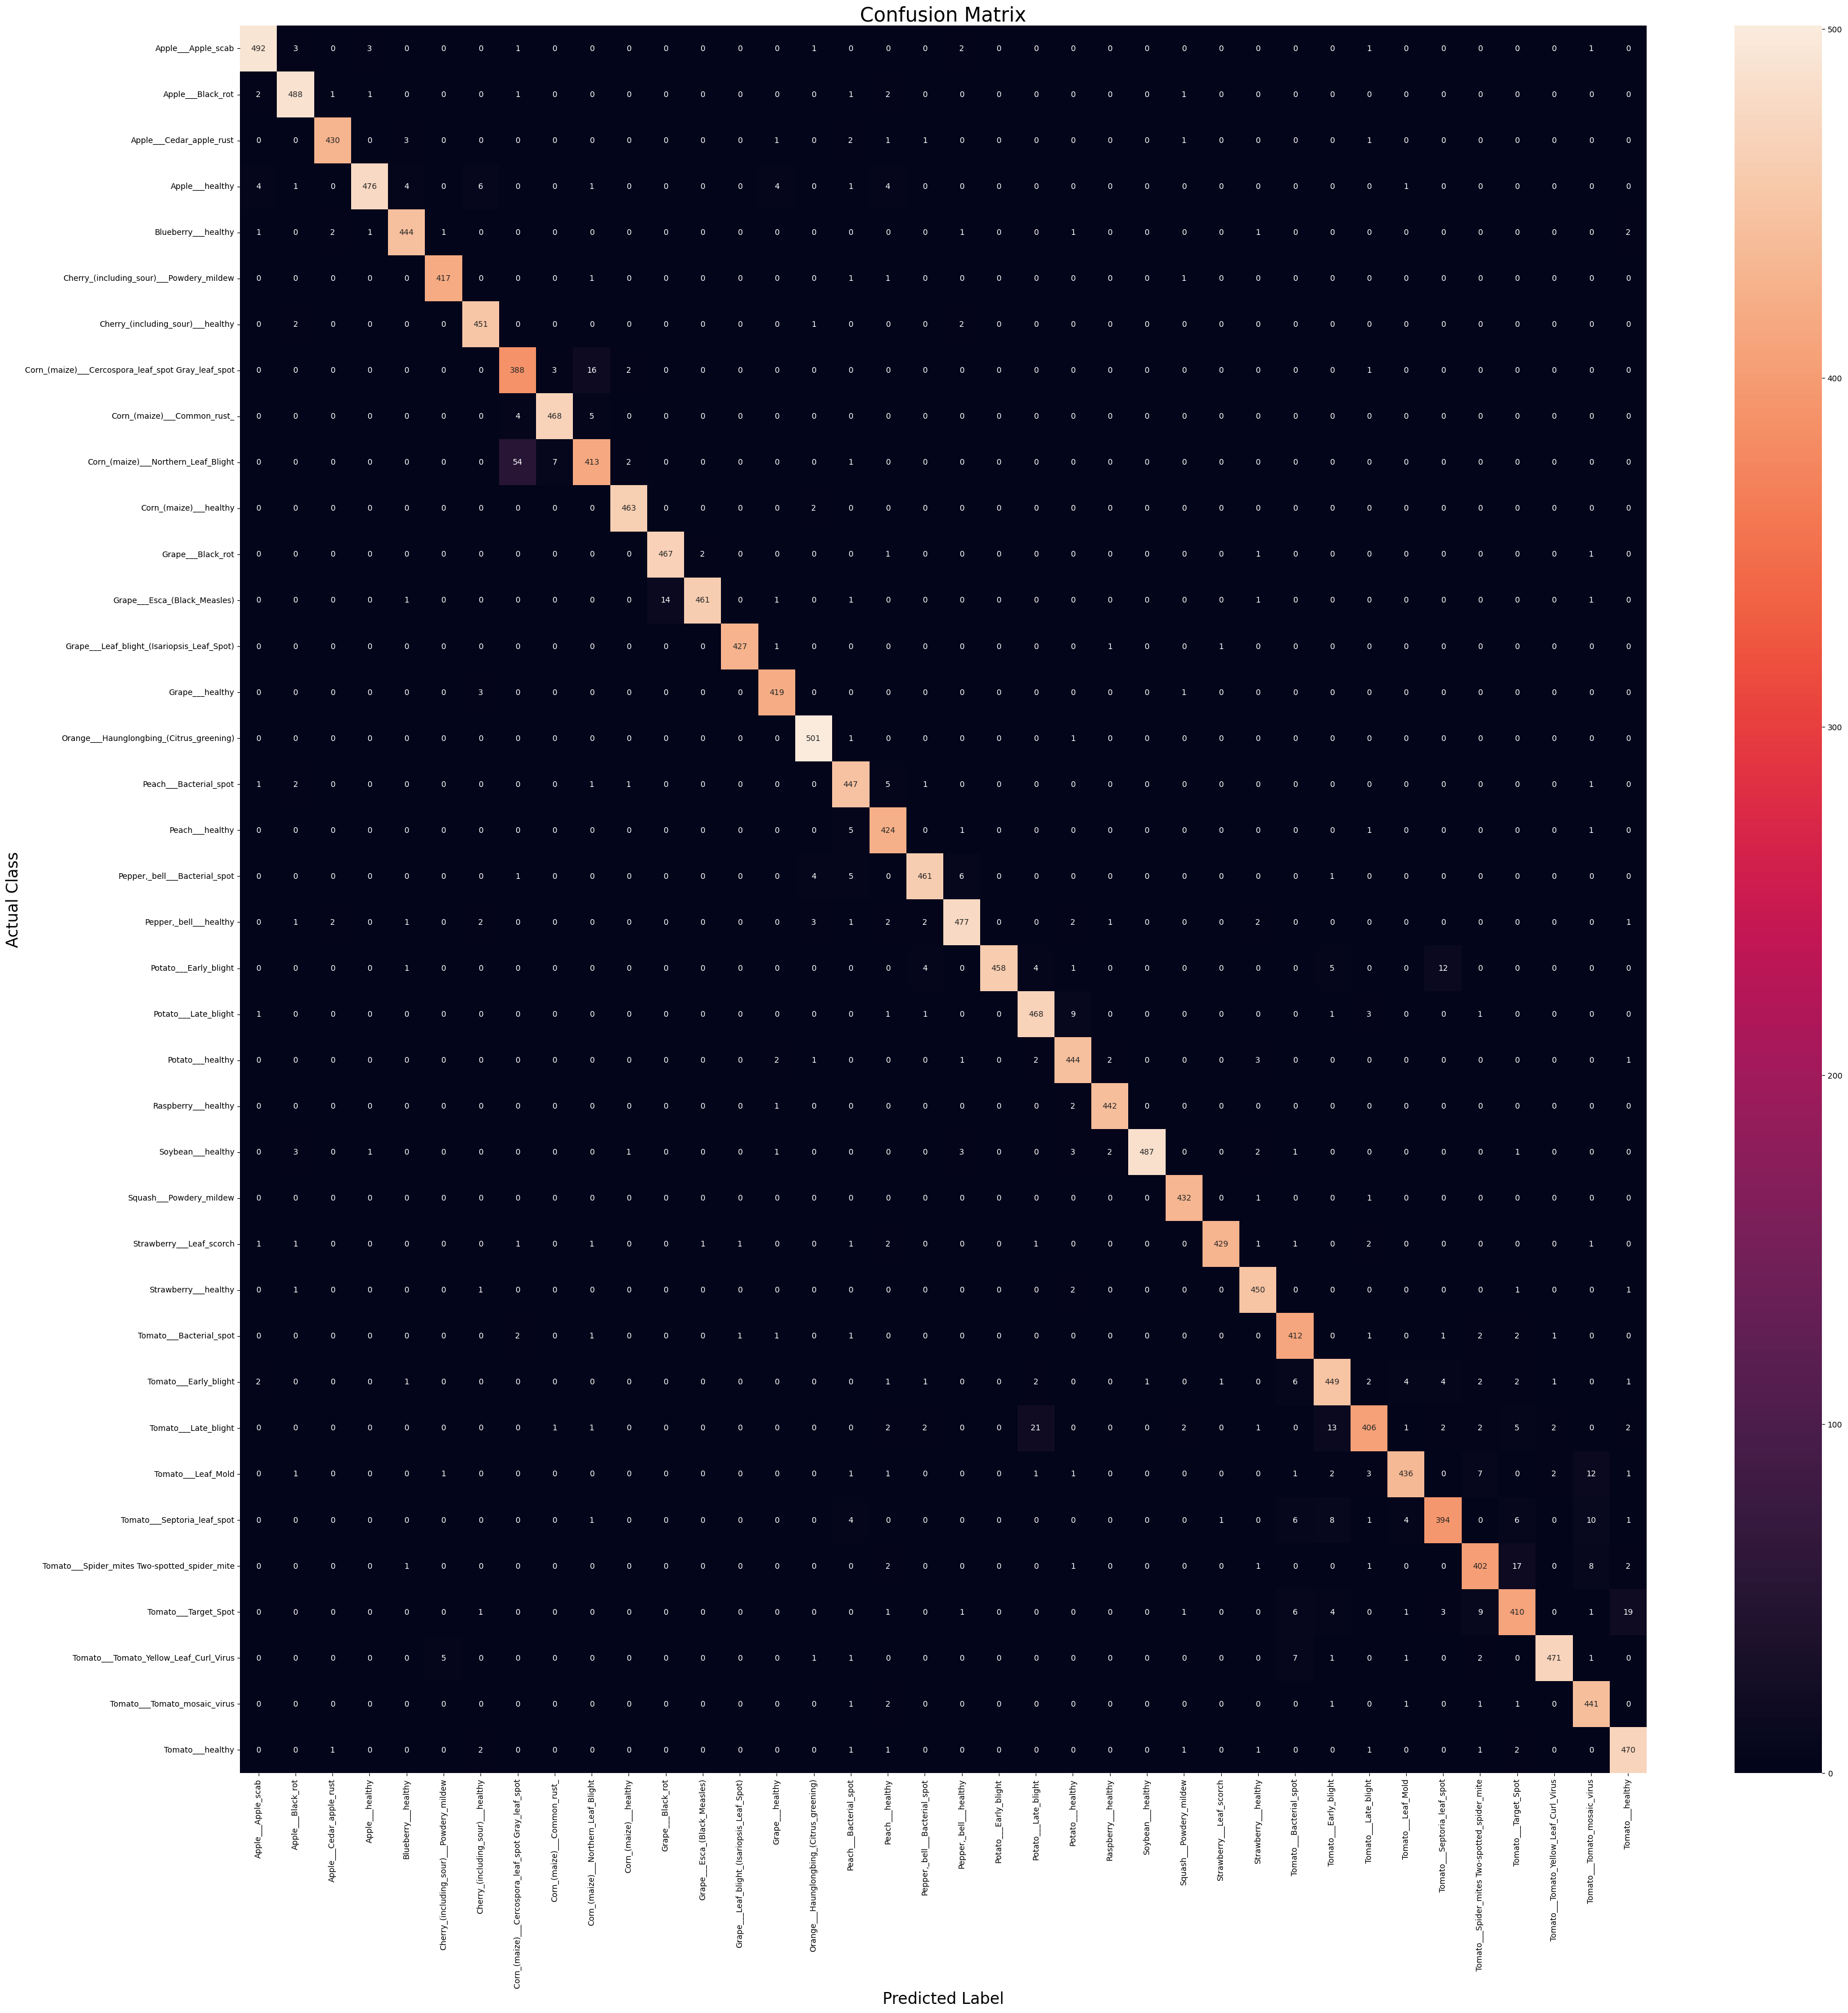

In [128]:
# Generate confusion matrix
cm = confusion_matrix(valid_labels, valid_preds, labels=range(len(class_names)))
plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 10}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.show()

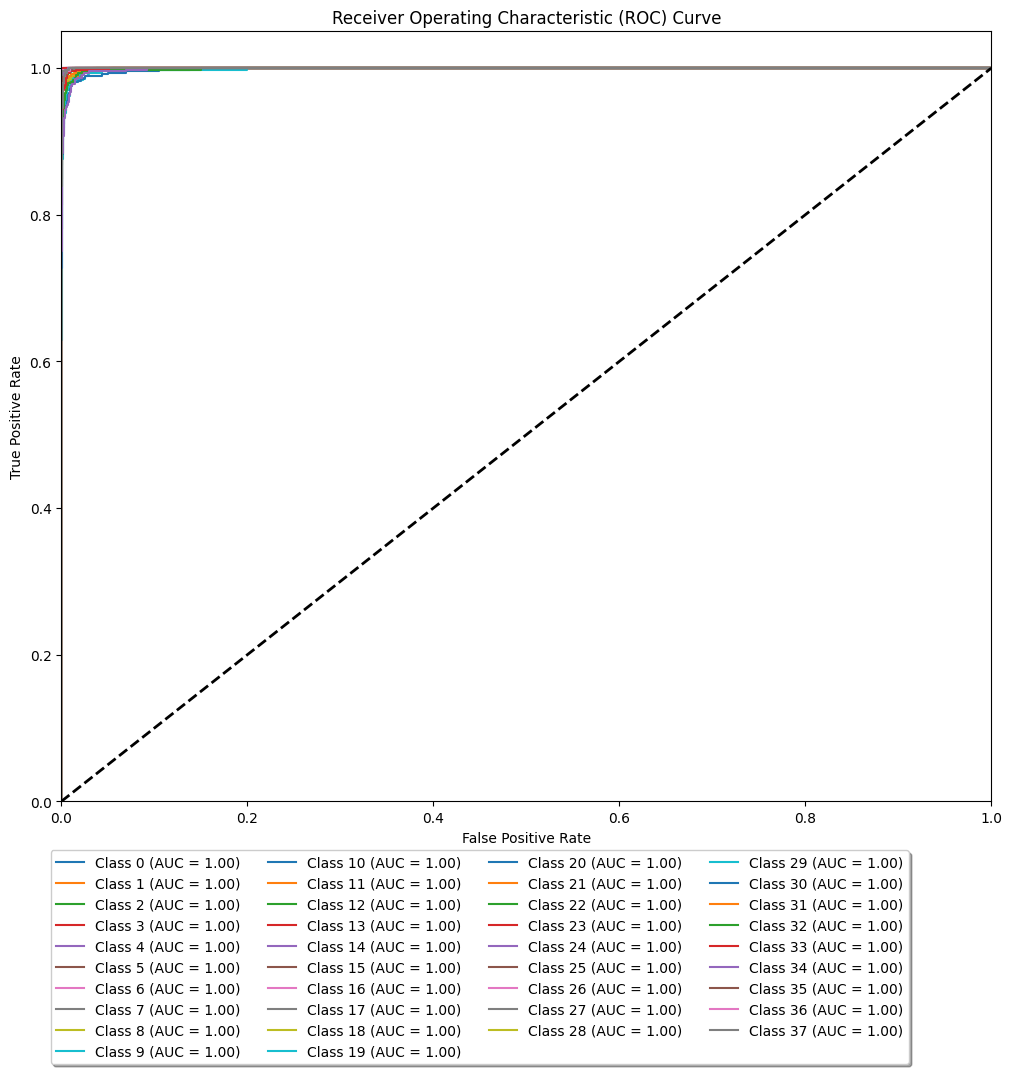

In [137]:
# Plot ROC curves
def plot_roc_curves(model, data_loader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
    
    # Binarize the labels
    y_true = label_binarize(all_labels, classes=range(num_classes))
    y_score = np.array(all_preds)
    
    # Compute ROC curves and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower center', bbox_to_anchor=(0.45, -0.35), fancybox=True, shadow=True, ncol=4)
    plt.show()
    
plot_roc_curves(model, valid_loader, num_classes=38)

## Resnet Model

In [143]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [144]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Load datasets
train_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [145]:
# Define the ResNet model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))

In [146]:
# Wrap model with DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [148]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Gradient accumulation settings
accumulation_steps = 4

# Train the model
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=1):
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss = loss / accumulation_steps  # Scale loss for gradient accumulation
            loss.backward()
            
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            # Statistics
            running_loss += loss.item() * accumulation_steps
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(valid_loader)
        val_acc = val_correct / val_total
        
        # Save history
        history['train_loss'].append(epoch_loss)
        history['valid_loss'].append(val_loss)
        history['train_acc'].append(epoch_acc)
        history['valid_acc'].append(val_acc)
        
        # Print the full summary for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"train_acc: {epoch_acc:.4f}, train_loss: {epoch_loss:.4f}, "
              f"valid_loss: {val_loss:.4f}, valid_acc: {val_acc:.4f}")
    
    return history


In [149]:
# Train the model
history = train_model(model, train_loader, valid_loader, criterion, optimizer)

Epoch 1/1: 100%|███████████████████████████████████████████████████████████████████| 4394/4394 [08:29<00:00,  8.63it/s]


Epoch [1/1], train_acc: 0.8526, train_loss: 0.5321, valid_loss: 0.1627, valid_acc: 0.9482


In [150]:
# Save the model
torch.save(model.state_dict(), 'resnet50.pth')
print("Model saved as resnet50.pth")

Model saved as resnet50.pth


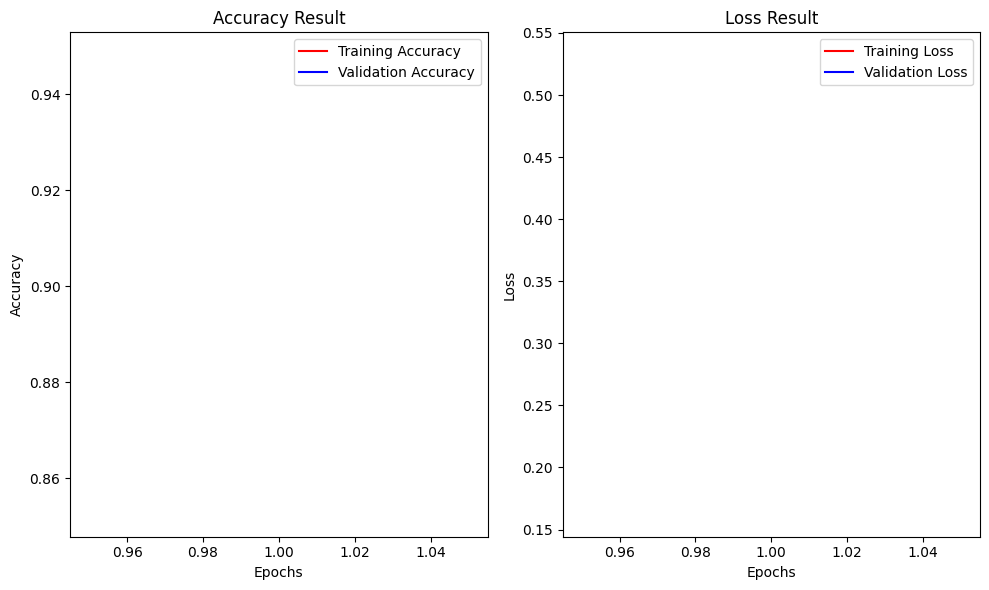

In [151]:
# Plotting results
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_acc'], 'r', label='Training Accuracy')
plt.plot(epochs, history['valid_acc'], 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Result')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'r', label='Training Loss')
plt.plot(epochs, history['valid_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Result')
plt.legend()

plt.tight_layout()
plt.show()


In [152]:
# Evaluate the model
def evaluate(model, data_loader):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            
            # Collect all labels and predictions for classification report
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = corrects.double() / total
    
    return avg_loss, accuracy, all_labels, all_preds

# Evaluate on the training set
train_loss, train_acc, train_labels, train_preds = evaluate(model, train_loader)
print(f'Training Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}')

# Evaluate on the validation set
valid_loss, valid_acc, valid_labels, valid_preds = evaluate(model, valid_loader)
print(f'Validation Loss: {valid_loss:.4f} Accuracy: {valid_acc:.4f}')

Training Loss: 0.1434 Accuracy: 0.9548
Validation Loss: 0.1519 Accuracy: 0.9507


In [153]:
# Generate classification report for training set
class_names = train_dataset.classes
print("Training Set Classification Report:")
print(classification_report(train_labels, train_preds, target_names=class_names))

Training Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.96      0.96      2016
                                 Apple___Black_rot       0.98      0.96      0.97      1987
                          Apple___Cedar_apple_rust       0.96      0.99      0.97      1760
                                   Apple___healthy       0.97      0.94      0.95      2008
                               Blueberry___healthy       0.97      0.98      0.98      1816
          Cherry_(including_sour)___Powdery_mildew       0.99      0.98      0.99      1683
                 Cherry_(including_sour)___healthy       0.97      0.99      0.98      1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.90      0.91      1642
                       Corn_(maize)___Common_rust_       0.96      0.99      0.98      1907
               Corn_(maize)___Northern_Leaf

In [154]:
# Generate classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(valid_labels, valid_preds, target_names=class_names))

Validation Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.95      0.96      0.96       504
                                 Apple___Black_rot       0.99      0.95      0.97       497
                          Apple___Cedar_apple_rust       0.95      0.99      0.97       440
                                   Apple___healthy       0.98      0.95      0.96       502
                               Blueberry___healthy       0.97      0.97      0.97       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.98      0.99       421
                 Cherry_(including_sour)___healthy       0.96      0.99      0.97       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.88      0.91       410
                       Corn_(maize)___Common_rust_       0.96      0.99      0.98       477
               Corn_(maize)___Northern_Le

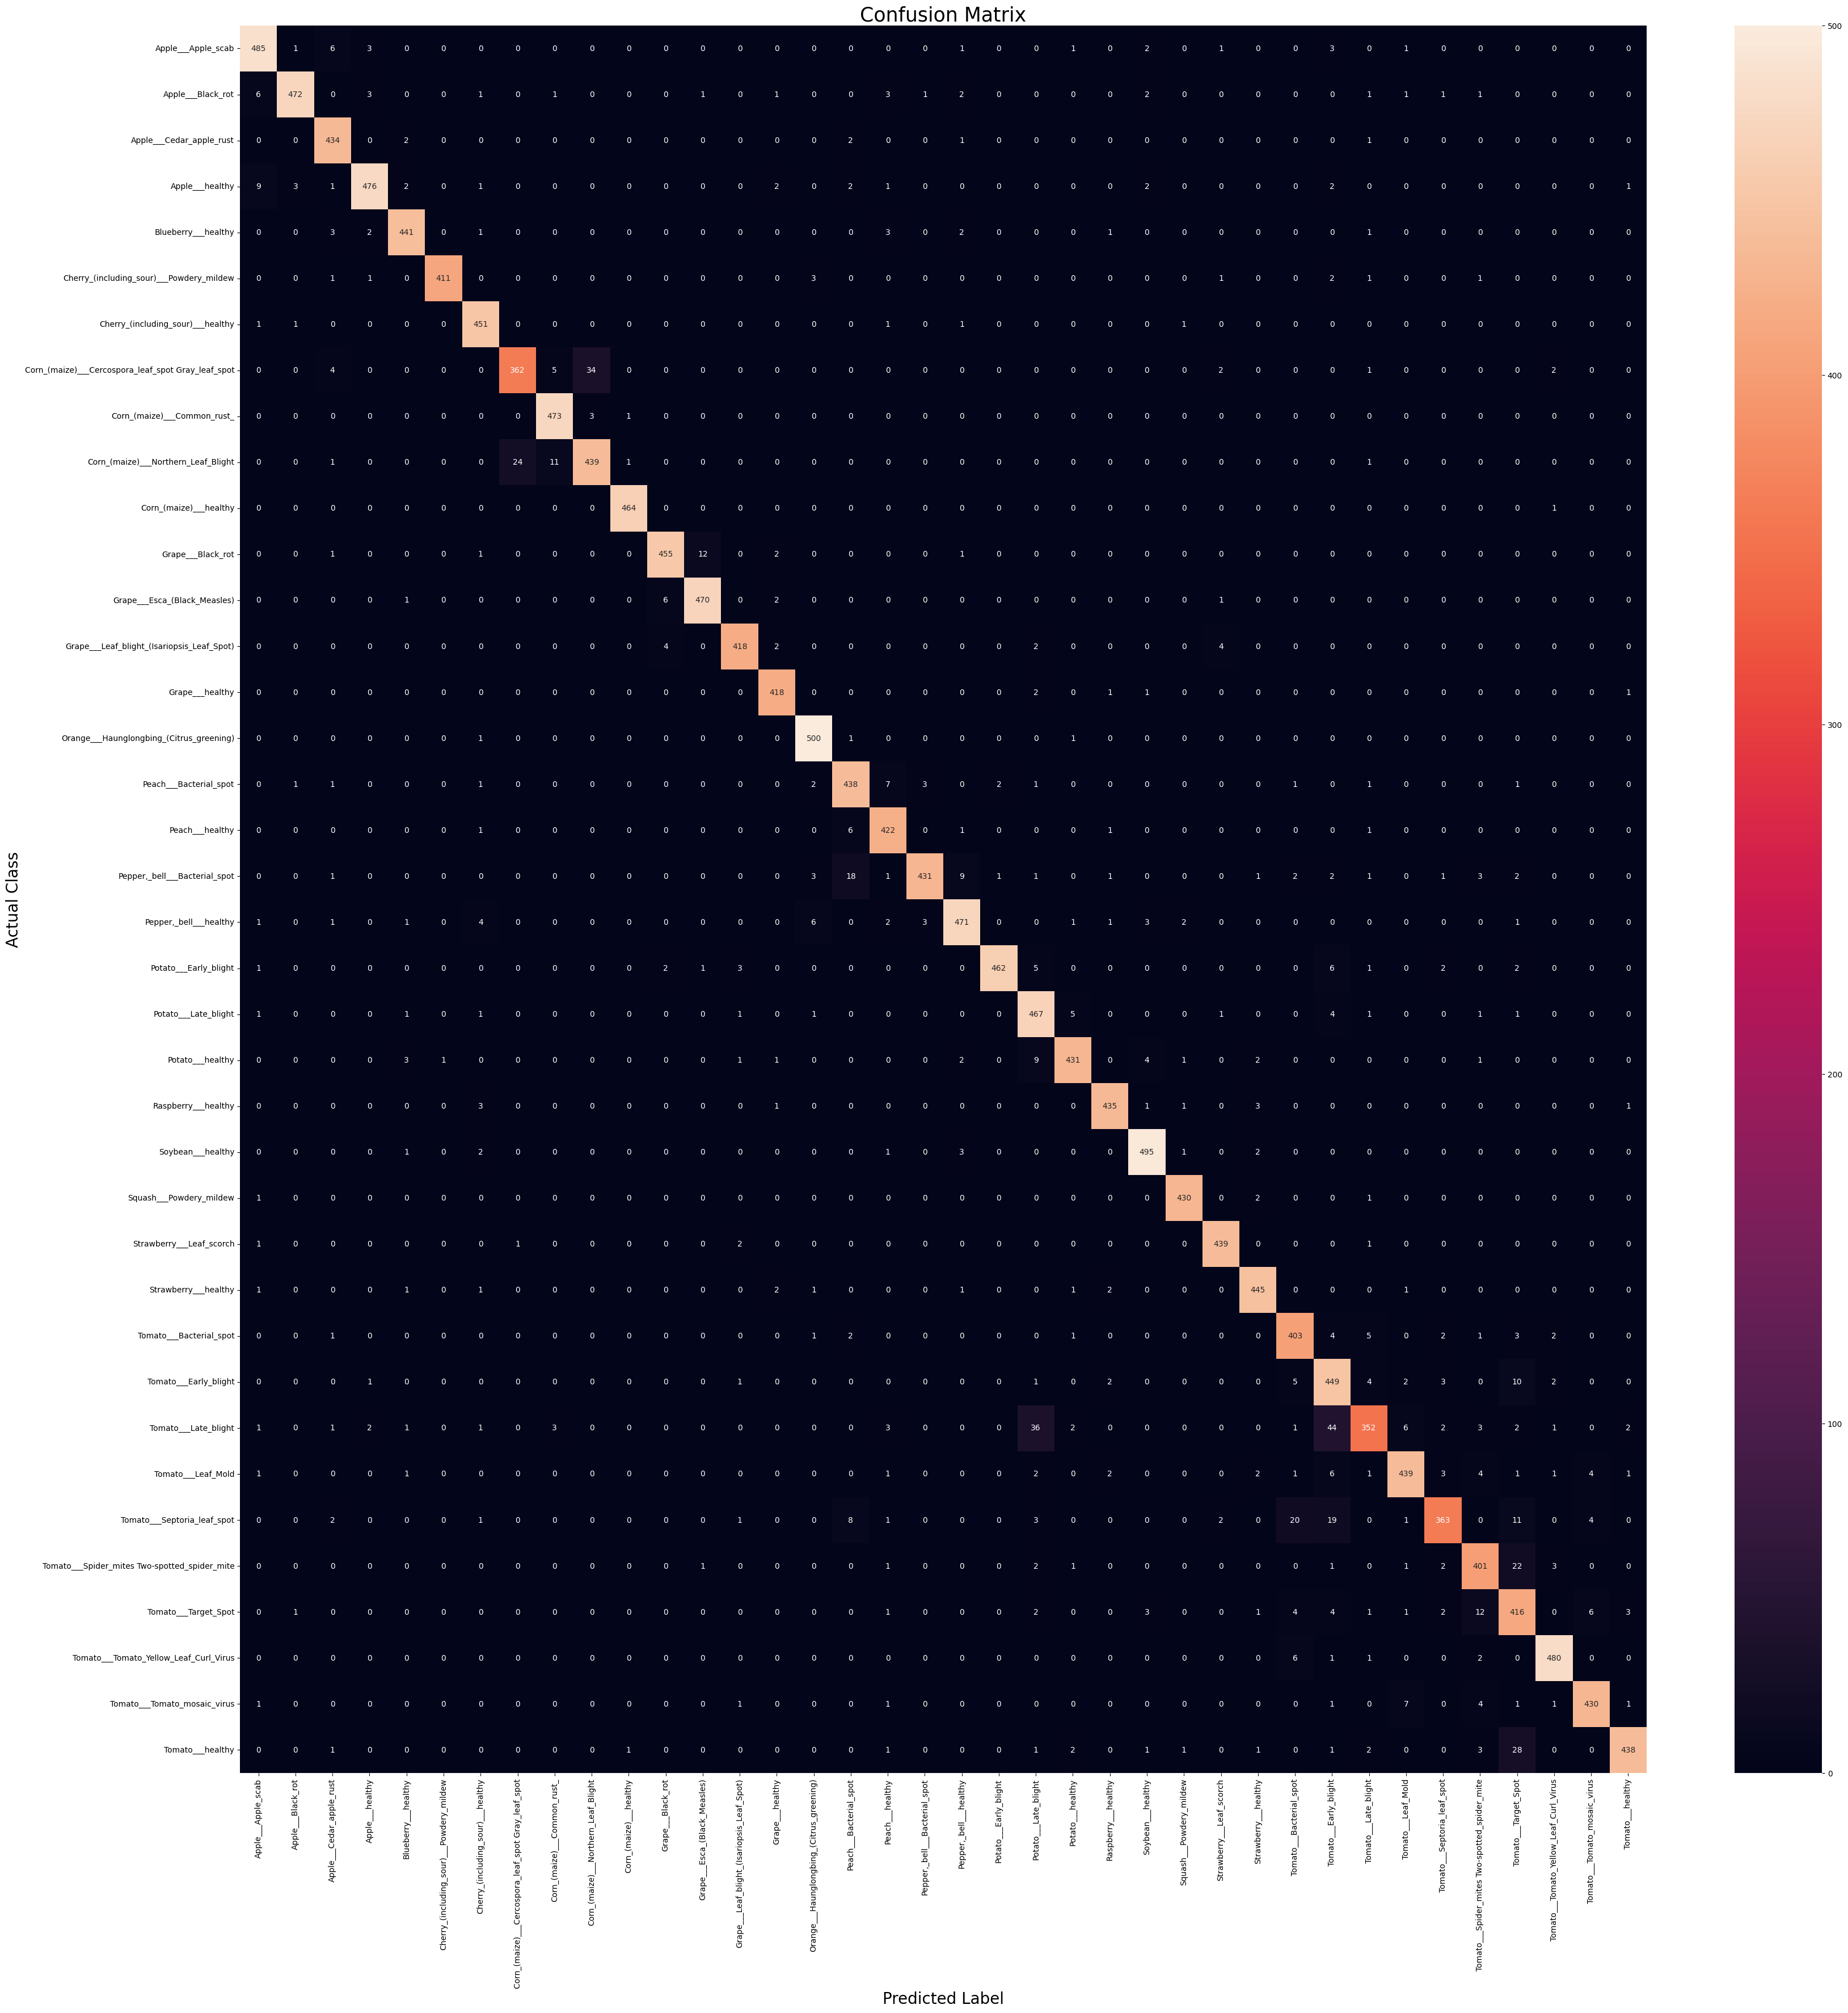

In [155]:
# Generate confusion matrix
cm = confusion_matrix(valid_labels, valid_preds, labels=range(len(class_names)))
plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 10}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.show()

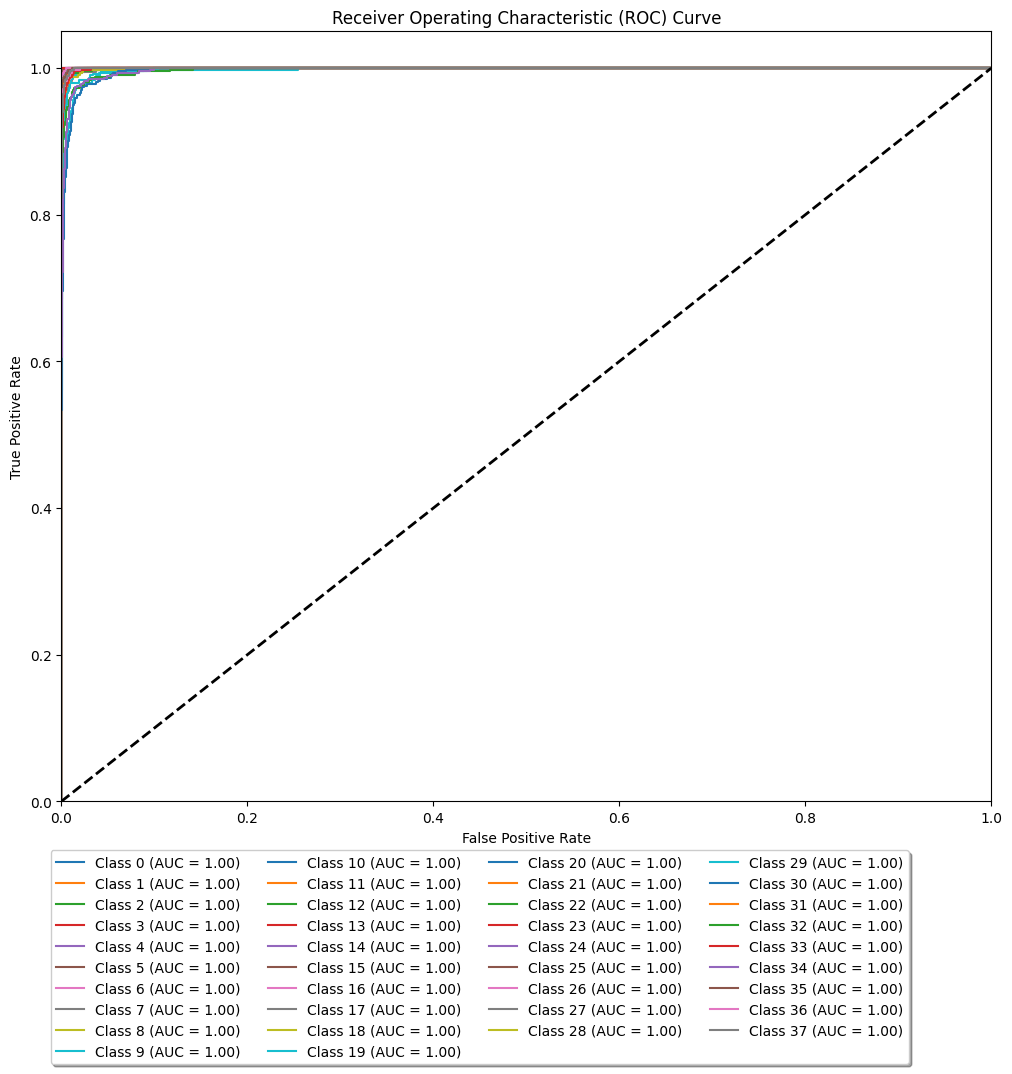

In [157]:
# Plot ROC curves
def plot_roc_curves(model, data_loader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
    
    # Binarize the labels
    y_true = label_binarize(all_labels, classes=range(num_classes))
    y_score = np.array(all_preds)
    
    # Compute ROC curves and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower center', bbox_to_anchor=(0.45, -0.35), fancybox=True, shadow=True, ncol=4)
    plt.show()

# Plot ROC curves for the validation set
plot_roc_curves(model, valid_loader, num_classes=len(class_names))

### VGG16 Model

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np

In [5]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [6]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = torchvision.datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/train', transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/valid', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
# Define the VGG16 model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(train_dataset.classes))

C:\Users\PREDATOR\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PREDATOR\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Wrap model with DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Gradient accumulation settings
accumulation_steps = 4

# Train the model
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=1):
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss = loss / accumulation_steps  # Scale loss for gradient accumulation
            loss.backward()
            
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            # Statistics
            running_loss += loss.item() * accumulation_steps
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(valid_loader)
        val_acc = val_correct / val_total
        
        # Save history
        history['train_loss'].append(epoch_loss)
        history['valid_loss'].append(val_loss)
        history['train_acc'].append(epoch_acc)
        history['valid_acc'].append(val_acc)
        
        # Print the full summary for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"train_acc: {epoch_acc:.4f}, train_loss: {epoch_loss:.4f}, "
              f"valid_loss: {val_loss:.4f}, valid_acc: {val_acc:.4f}")
    
    return history

In [10]:
# Train the model
history = train_model(model, train_loader, valid_loader, criterion, optimizer)

Epoch 1/1: 100%|███████████████████████████████████████████████████████████████████| 4394/4394 [17:52<00:00,  4.10it/s]


Epoch [1/1], train_acc: 0.7643, train_loss: 0.7781, valid_loss: 0.4282, valid_acc: 0.8697


In [11]:
# Save the model
torch.save(model.state_dict(), 'vgg16.pth')
print("Model saved as vgg16.pth")

Model saved as vgg16.pth


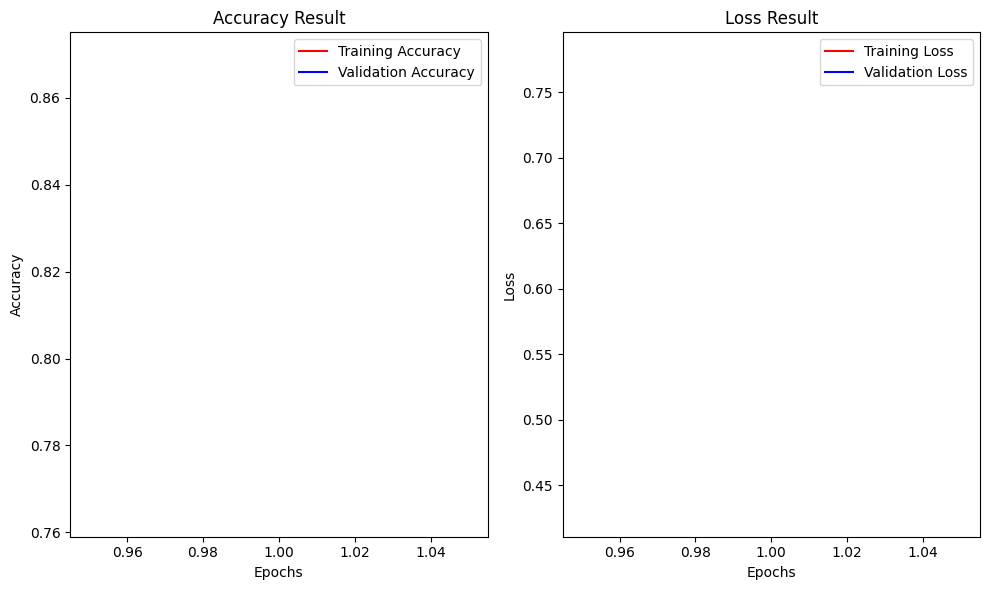

In [12]:
# Plotting results
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_acc'], 'r', label='Training Accuracy')
plt.plot(epochs, history['valid_acc'], 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Result')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'r', label='Training Loss')
plt.plot(epochs, history['valid_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Result')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Evaluate the model
def evaluate(model, data_loader):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            
            # Collect all labels and predictions for classification report
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = corrects.double() / total
    
    return avg_loss, accuracy, all_labels, all_preds

# Evaluate on the training set
train_loss, train_acc, train_labels, train_preds = evaluate(model, train_loader)
print(f'Training Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}')

# Evaluate on the validation set
valid_loss, valid_acc, valid_labels, valid_preds = evaluate(model, valid_loader)
print(f'Validation Loss: {valid_loss:.4f} Accuracy: {valid_acc:.4f}')

Training Loss: 0.4093 Accuracy: 0.8755
Validation Loss: 0.4301 Accuracy: 0.8705


In [14]:
# Generate classification report for training set
class_names = train_dataset.classes
print("Training Set Classification Report:")
print(classification_report(train_labels, train_preds, target_names=class_names))


Training Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.81      0.88      2016
                                 Apple___Black_rot       0.92      0.90      0.91      1987
                          Apple___Cedar_apple_rust       0.97      0.90      0.93      1760
                                   Apple___healthy       0.91      0.85      0.88      2008
                               Blueberry___healthy       0.93      0.94      0.93      1816
          Cherry_(including_sour)___Powdery_mildew       0.89      0.97      0.93      1683
                 Cherry_(including_sour)___healthy       0.85      0.96      0.90      1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.84      0.93      0.89      1642
                       Corn_(maize)___Common_rust_       0.92      0.98      0.95      1907
               Corn_(maize)___Northern_Leaf

In [15]:
# Generate classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(valid_labels, valid_preds, target_names=class_names))


Validation Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.80      0.87       504
                                 Apple___Black_rot       0.93      0.90      0.92       497
                          Apple___Cedar_apple_rust       0.96      0.86      0.91       440
                                   Apple___healthy       0.90      0.84      0.87       502
                               Blueberry___healthy       0.91      0.94      0.93       454
          Cherry_(including_sour)___Powdery_mildew       0.88      0.97      0.93       421
                 Cherry_(including_sour)___healthy       0.86      0.97      0.91       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.84      0.92      0.88       410
                       Corn_(maize)___Common_rust_       0.92      0.98      0.95       477
               Corn_(maize)___Northern_Le

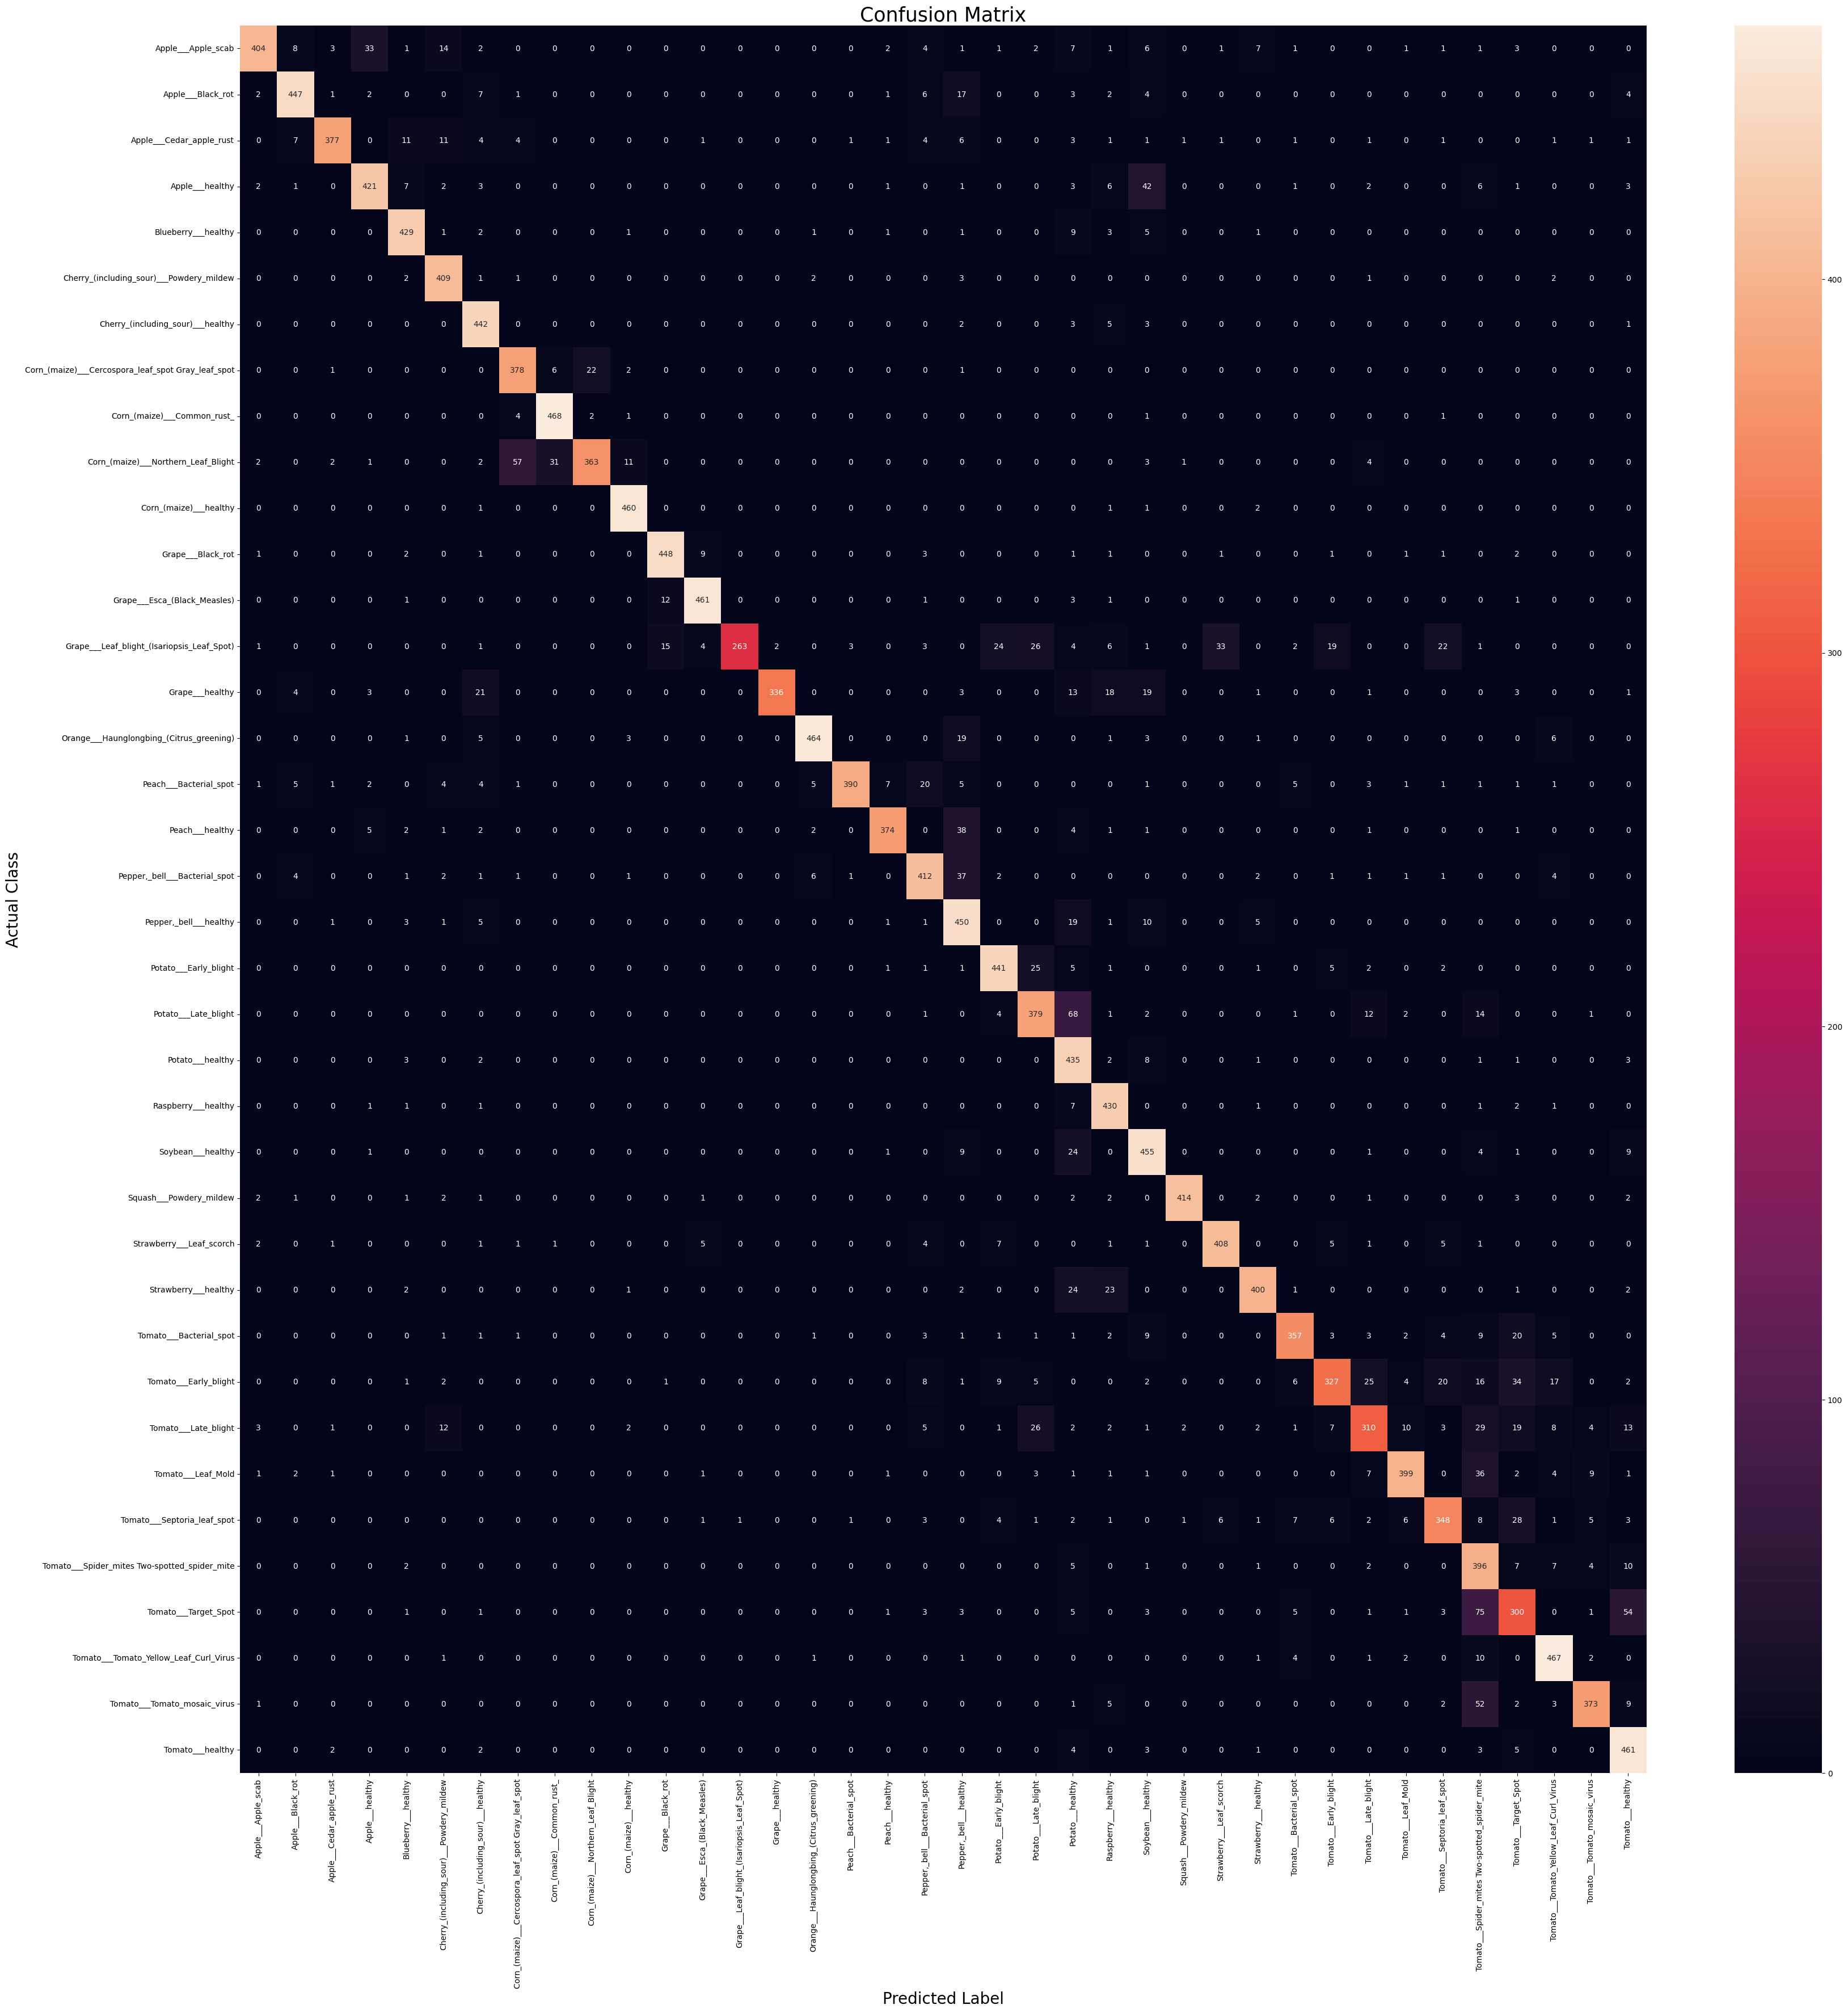

In [16]:
# Generate confusion matrix
cm = confusion_matrix(valid_labels, valid_preds, labels=range(len(class_names)))
plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 10}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.show()


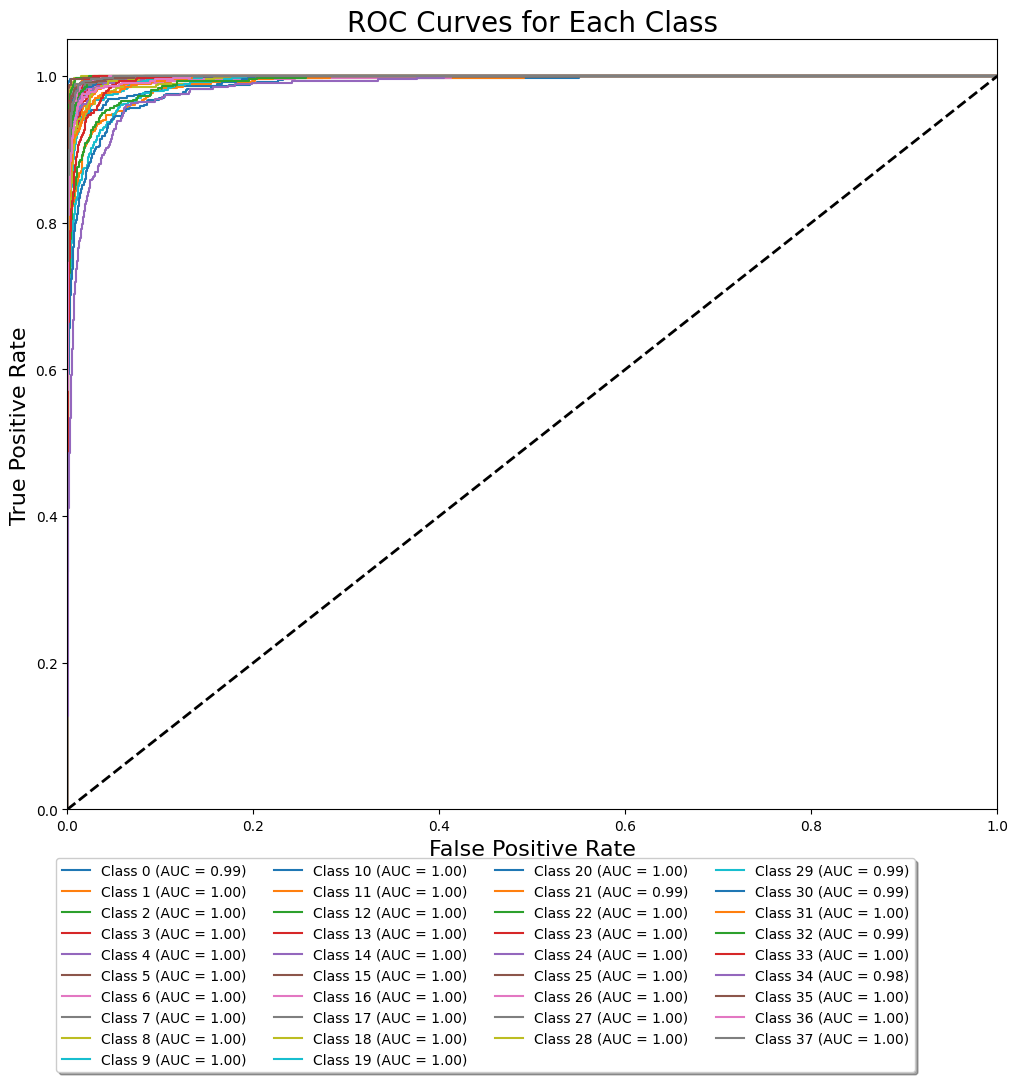

In [18]:
# Plot ROC curves
def plot_roc_curves(model, data_loader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
    
    # Binarize the labels
    y_true = label_binarize(all_labels, classes=range(num_classes))
    y_score = np.array(all_preds)
    
    # Compute ROC curves and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC Curves for Each Class', fontsize=20)
    plt.legend(loc='lower center', bbox_to_anchor=(0.45, -0.35), fancybox=True, shadow=True, ncol=4)
    plt.show()

# Plot ROC curves for validation set
plot_roc_curves(model, valid_loader, len(class_names))

### VGG19 Model

In [19]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [20]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [21]:
# Define the VGG19 model
model = models.vgg19(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(train_dataset.classes))

C:\Users\PREDATOR\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PREDATOR\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\PREDATOR/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [01:17<00:00, 7.42MB/s]


In [22]:
# Wrap model with DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [23]:

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Gradient accumulation settings
accumulation_steps = 4

# Train the model
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=1):
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss = loss / accumulation_steps  # Scale loss for gradient accumulation
            loss.backward()
            
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            
            # Statistics
            running_loss += loss.item() * accumulation_steps
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(valid_loader)
        val_acc = val_correct / val_total
        
        # Save history
        history['train_loss'].append(epoch_loss)
        history['valid_loss'].append(val_loss)
        history['train_acc'].append(epoch_acc)
        history['valid_acc'].append(val_acc)
        
        # Print the full summary for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"train_acc: {epoch_acc:.4f}, train_loss: {epoch_loss:.4f}, "
              f"valid_loss: {val_loss:.4f}, valid_acc: {val_acc:.4f}")
    
    return history


In [24]:
# Train the model
history = train_model(model, train_loader, valid_loader, criterion, optimizer)

Epoch 1/1: 100%|███████████████████████████████████████████████████████████████████| 4394/4394 [21:17<00:00,  3.44it/s]


Epoch [1/1], train_acc: 0.7370, train_loss: 0.8692, valid_loss: 0.5263, valid_acc: 0.8351


In [25]:
# Save the model
torch.save(model.state_dict(), 'vgg19.pth')
print("Model saved as vgg19.pth")

Model saved as vgg19.pth


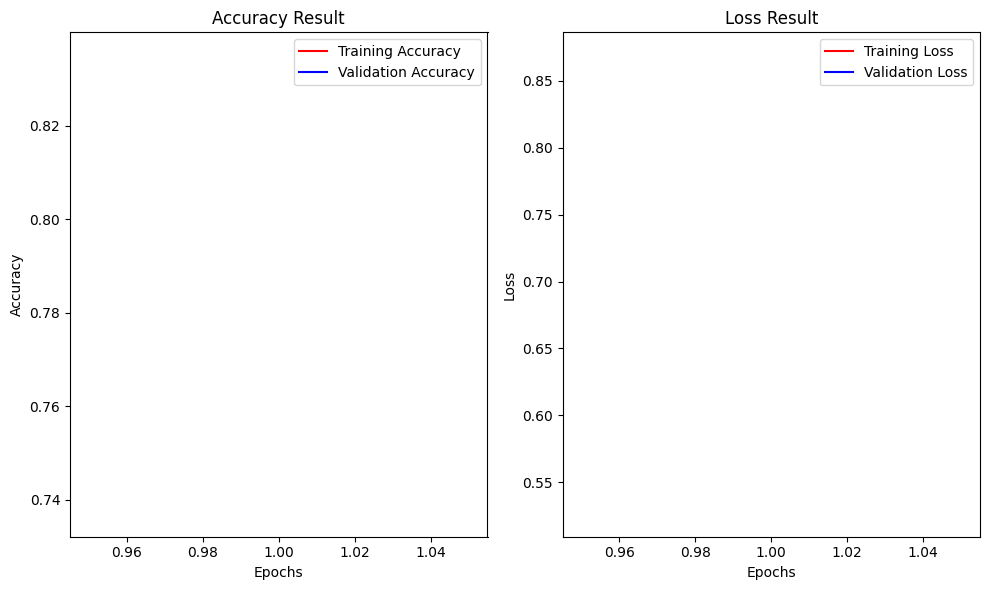

In [26]:

# Plotting results
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_acc'], 'r', label='Training Accuracy')
plt.plot(epochs, history['valid_acc'], 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Result')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'r', label='Training Loss')
plt.plot(epochs, history['valid_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Result')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
# Evaluate the model
def evaluate(model, data_loader):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            
            # Collect all labels and predictions for classification report
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = corrects.double() / total
    
    return avg_loss, accuracy, all_labels, all_preds

# Evaluate on the training set
train_loss, train_acc, train_labels, train_preds = evaluate(model, train_loader)
print(f'Training Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}')

# Evaluate on the validation set
valid_loss, valid_acc, valid_labels, valid_preds = evaluate(model, valid_loader)
print(f'Validation Loss: {valid_loss:.4f} Accuracy: {valid_acc:.4f}')


Training Loss: 0.5158 Accuracy: 0.8396
Validation Loss: 0.5361 Accuracy: 0.8346


In [28]:
# Generate classification report for training set
class_names = train_dataset.classes
print("Training Set Classification Report:")
print(classification_report(train_labels, train_preds, target_names=class_names))


Training Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.76      0.85      2016
                                 Apple___Black_rot       0.86      0.88      0.87      1987
                          Apple___Cedar_apple_rust       0.96      0.89      0.92      1760
                                   Apple___healthy       0.72      0.84      0.77      2008
                               Blueberry___healthy       0.99      0.80      0.89      1816
          Cherry_(including_sour)___Powdery_mildew       0.98      0.73      0.84      1683
                 Cherry_(including_sour)___healthy       0.92      0.95      0.94      1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.79      0.91      0.85      1642
                       Corn_(maize)___Common_rust_       0.97      0.93      0.95      1907
               Corn_(maize)___Northern_Leaf

In [29]:
# Generate classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(valid_labels, valid_preds, target_names=class_names))


Validation Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.75      0.85       504
                                 Apple___Black_rot       0.87      0.88      0.87       497
                          Apple___Cedar_apple_rust       0.95      0.89      0.92       440
                                   Apple___healthy       0.73      0.83      0.78       502
                               Blueberry___healthy       1.00      0.80      0.88       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.72      0.84       421
                 Cherry_(including_sour)___healthy       0.93      0.94      0.94       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.79      0.91      0.85       410
                       Corn_(maize)___Common_rust_       0.99      0.93      0.96       477
               Corn_(maize)___Northern_Le

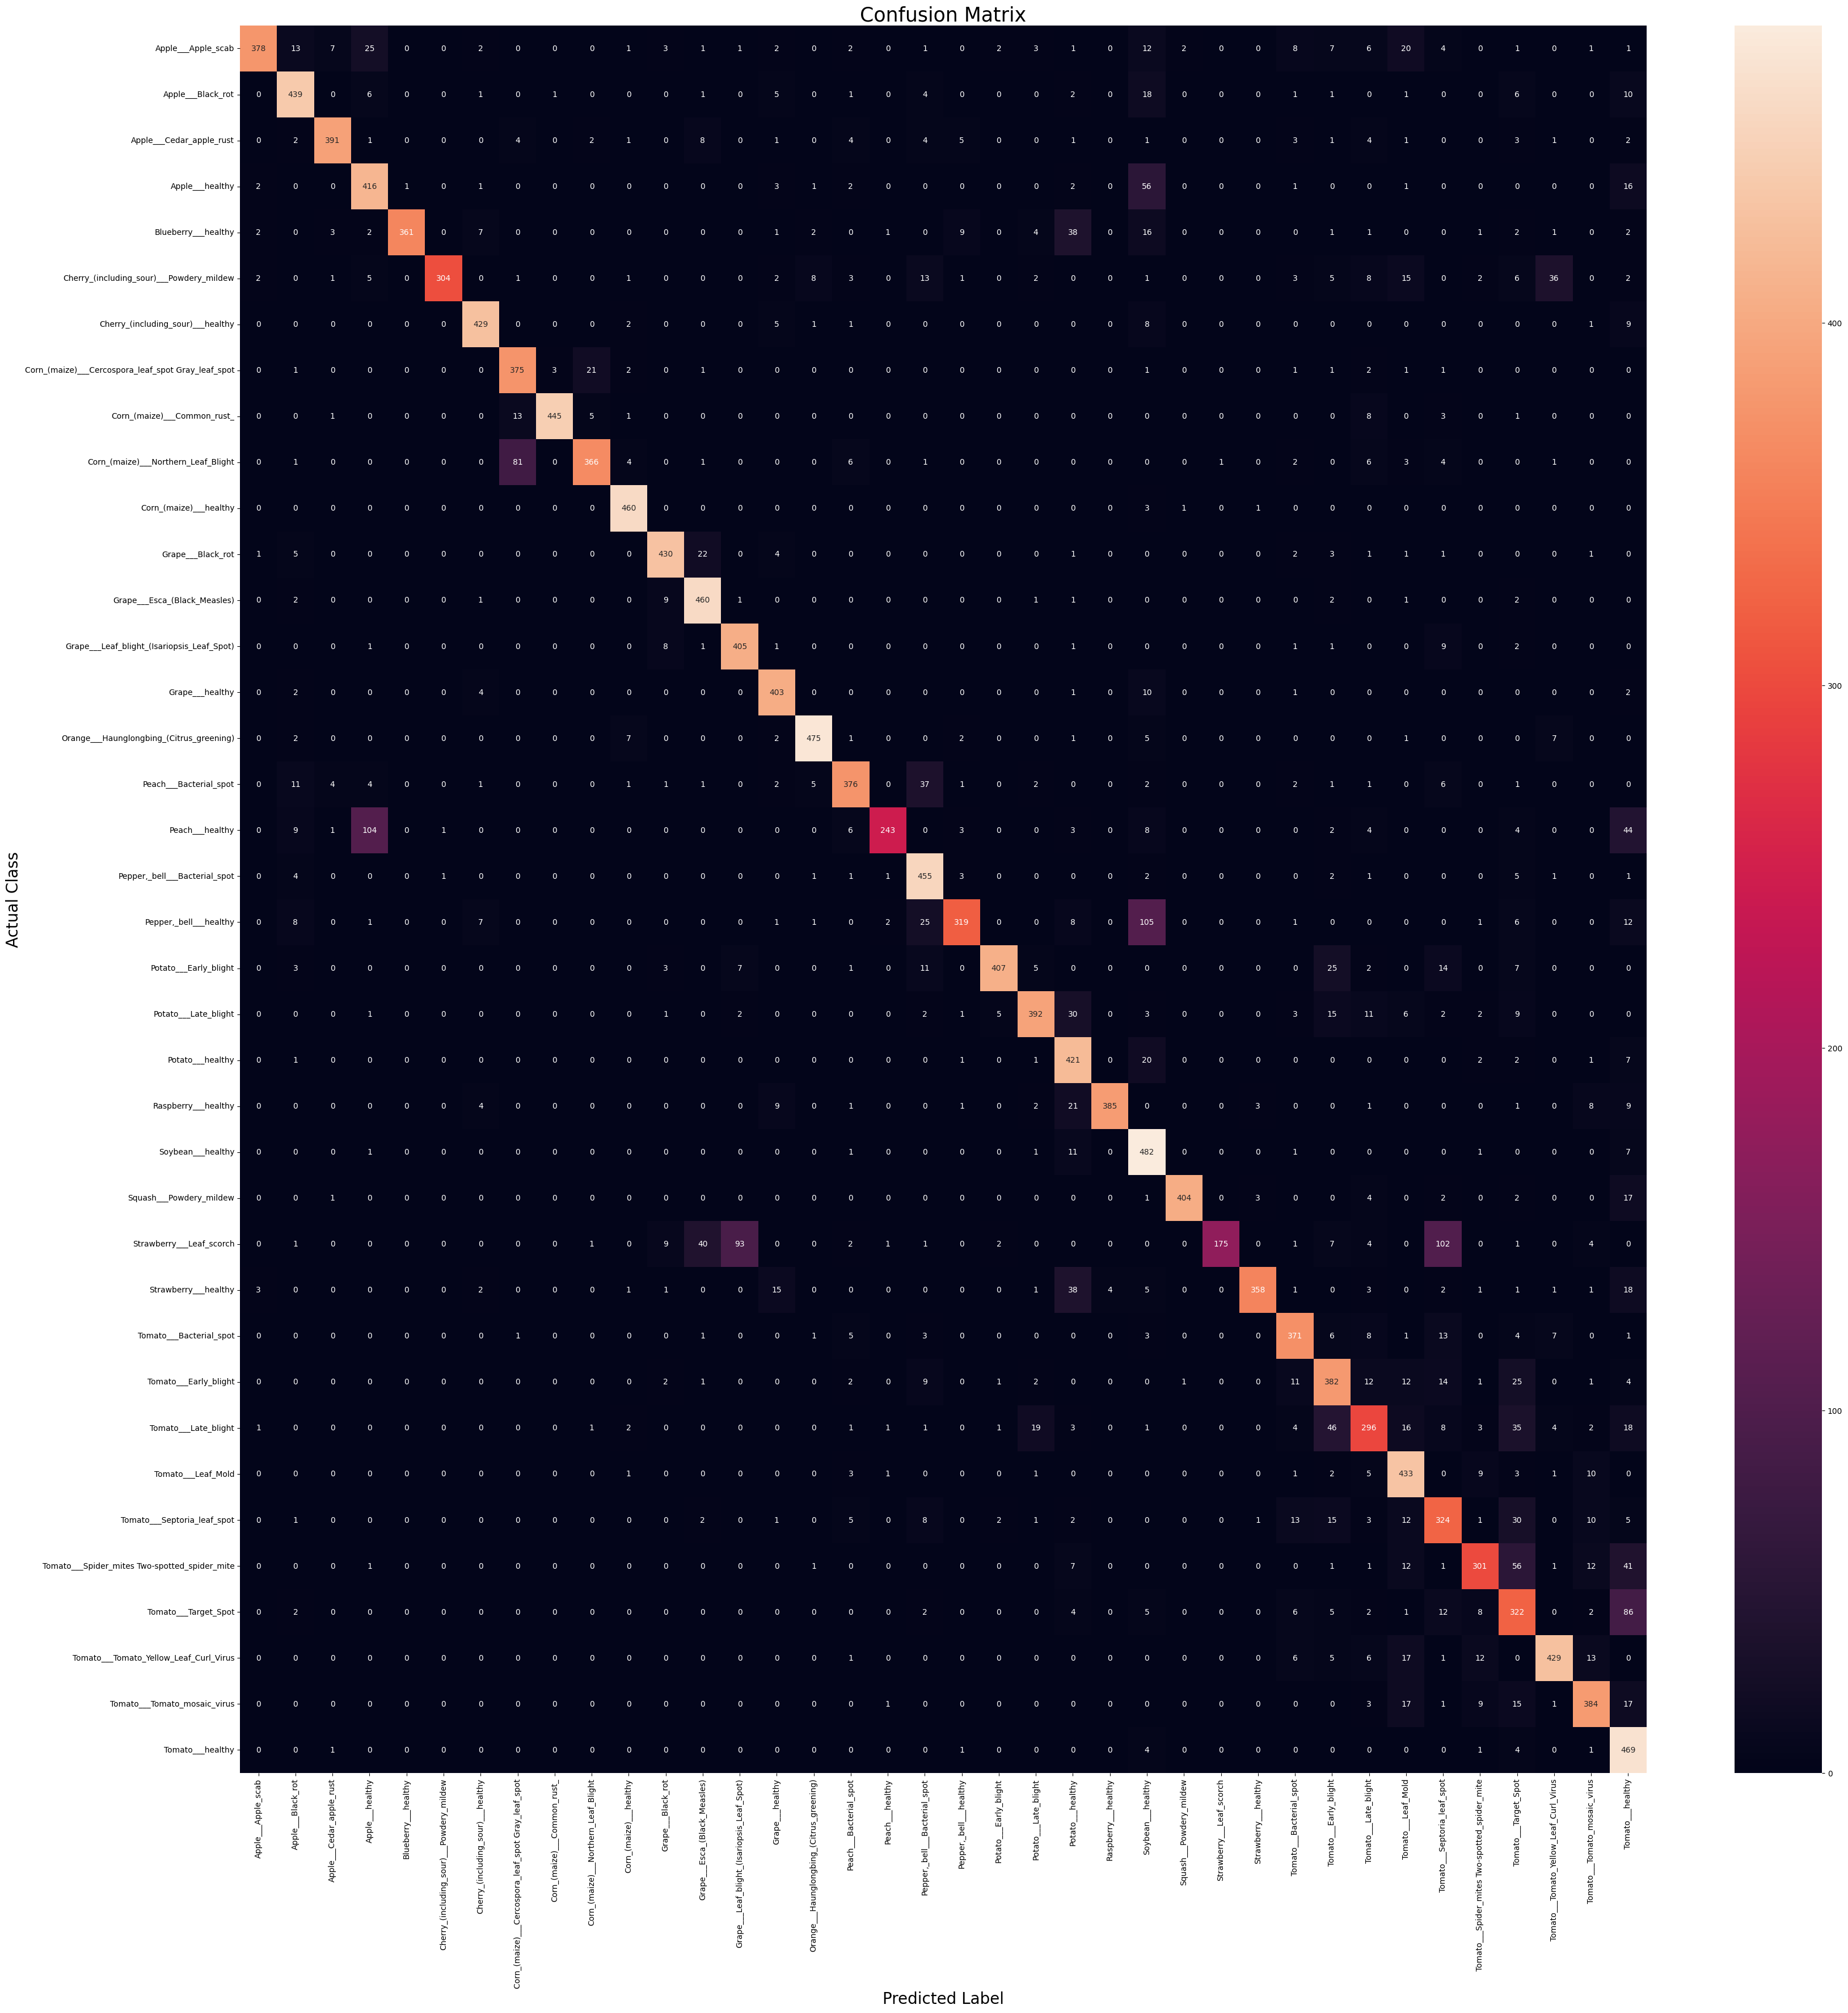

In [30]:
# Generate confusion matrix
cm = confusion_matrix(valid_labels, valid_preds, labels=range(len(class_names)))
plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 10}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.show()


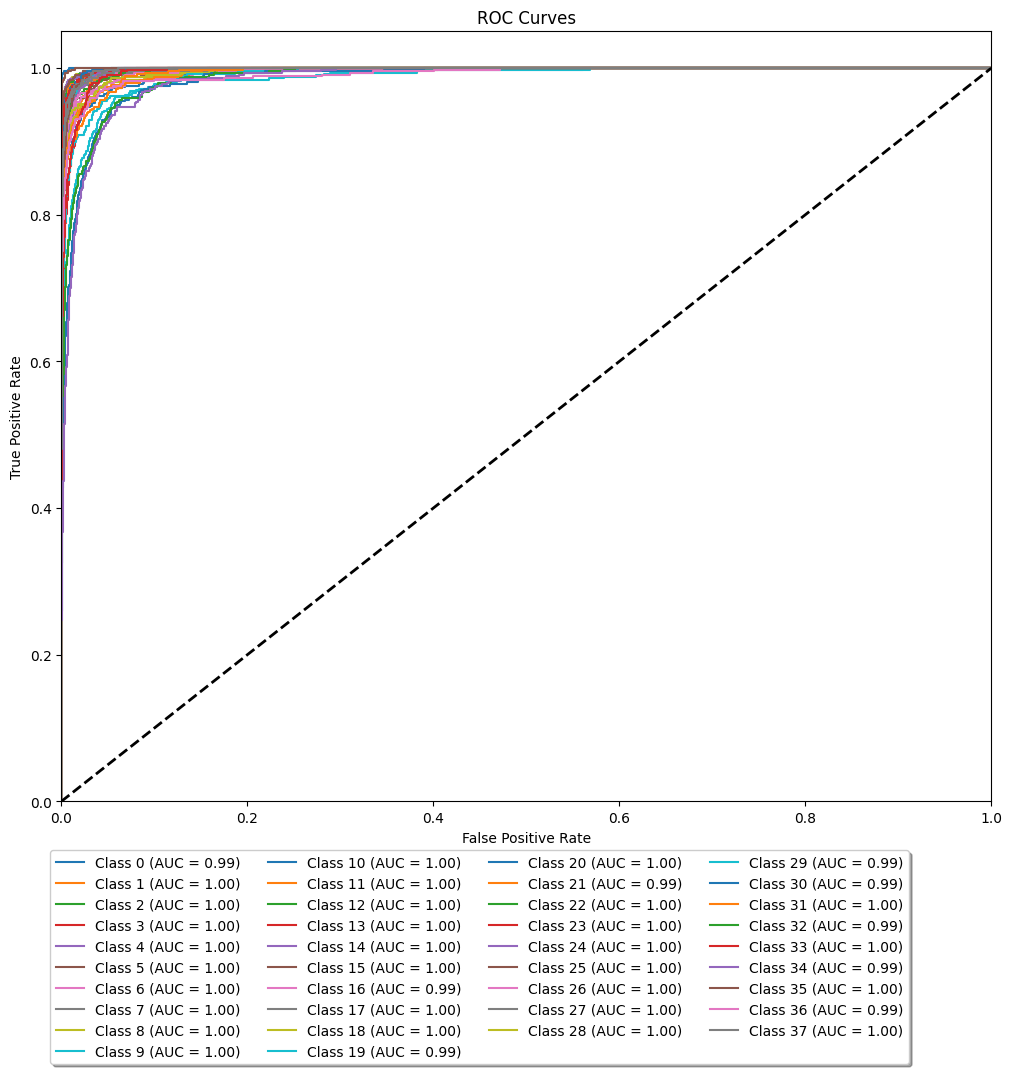

In [31]:
# Plot ROC curves
def plot_roc_curves(model, data_loader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
    
    # Binarize the labels
    y_true = label_binarize(all_labels, classes=range(num_classes))
    y_score = np.array(all_preds)
    
    # Compute ROC curves and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower center', bbox_to_anchor=(0.45, -0.35), fancybox=True, shadow=True, ncol=4)
    plt.show()

plot_roc_curves(model, valid_loader, len(train_dataset.classes))

## AlexNet

In [32]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [33]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [34]:
# Define the AlexNet model
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(train_dataset.classes))

C:\Users\PREDATOR\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PREDATOR\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\PREDATOR/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|███████████████████████████████████████████████████████████████████████████████| 233M/233M [00:38<00:00, 6.33MB/s]


In [35]:
# Wrap model with DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [36]:
# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Gradient accumulation settings
accumulation_steps = 4

# Train the model
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=1):
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch') as tepoch:
            for i, (images, labels) in enumerate(tepoch):
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss = loss / accumulation_steps  # Scale loss for gradient accumulation
                loss.backward()
                
                if (i + 1) % accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
                
                # Statistics
                running_loss += loss.item() * accumulation_steps
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar description
                tepoch.set_postfix(train_loss=running_loss / total, train_acc=correct / total)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(valid_loader)
        val_acc = val_correct / val_total
        
        # Save history
        history['train_loss'].append(epoch_loss)
        history['valid_loss'].append(val_loss)
        history['train_acc'].append(epoch_acc)
        history['valid_acc'].append(val_acc)
        
        # Print the full summary for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"train_acc: {epoch_acc:.4f}, train_loss: {epoch_loss:.4f}, "
              f"valid_loss: {val_loss:.4f}, valid_acc: {val_acc:.4f}")
    
    return history


In [37]:
# Train the model
history = train_model(model, train_loader, valid_loader, criterion, optimizer)

Epoch 1/1: 100%|█████████████████████████████| 4394/4394 [02:09<00:00, 34.05batch/s, train_acc=0.75, train_loss=0.0507]


Epoch [1/1], train_acc: 0.7505, train_loss: 0.8115, valid_loss: 0.4490, valid_acc: 0.8587


In [38]:
# Save the model
torch.save(model.state_dict(), 'alexnet.pth')
print("Model saved as alexnet.pth")

Model saved as alexnet.pth


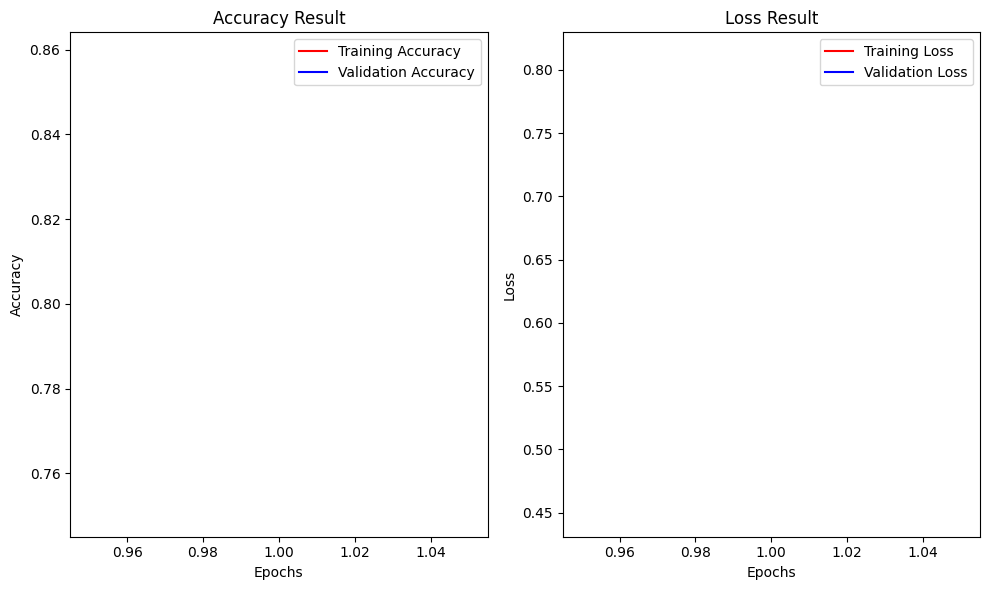

In [39]:

# Plotting results
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_acc'], 'r', label='Training Accuracy')
plt.plot(epochs, history['valid_acc'], 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Result')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'r', label='Training Loss')
plt.plot(epochs, history['valid_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Result')
plt.legend()

plt.tight_layout()
plt.show()


In [40]:

# Evaluate the model
def evaluate(model, data_loader):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            
            # Collect all labels and predictions for classification report
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = corrects.double() / total
    
    return avg_loss, accuracy, all_labels, all_preds

# Evaluate on the training set
train_loss, train_acc, train_labels, train_preds = evaluate(model, train_loader)
print(f'Training Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}')

# Evaluate on the validation set
valid_loss, valid_acc, valid_labels, valid_preds = evaluate(model, valid_loader)
print(f'Validation Loss: {valid_loss:.4f} Accuracy: {valid_acc:.4f}')


Training Loss: 0.4375 Accuracy: 0.8596
Validation Loss: 0.4484 Accuracy: 0.8564


In [41]:
# Generate classification report for training set
class_names = train_dataset.classes
print("Training Set Classification Report:")
print(classification_report(train_labels, train_preds, target_names=class_names))


Training Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.91      0.80      0.85      2016
                                 Apple___Black_rot       0.84      0.88      0.86      1987
                          Apple___Cedar_apple_rust       0.93      0.91      0.92      1760
                                   Apple___healthy       0.81      0.89      0.85      2008
                               Blueberry___healthy       0.87      0.93      0.90      1816
          Cherry_(including_sour)___Powdery_mildew       0.92      0.95      0.94      1683
                 Cherry_(including_sour)___healthy       0.92      0.93      0.92      1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.74      0.83      1642
                       Corn_(maize)___Common_rust_       0.87      0.99      0.92      1907
               Corn_(maize)___Northern_Leaf

In [42]:
# Generate classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(valid_labels, valid_preds, target_names=class_names))


Validation Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.92      0.82      0.87       504
                                 Apple___Black_rot       0.83      0.90      0.87       497
                          Apple___Cedar_apple_rust       0.94      0.93      0.93       440
                                   Apple___healthy       0.83      0.88      0.86       502
                               Blueberry___healthy       0.84      0.94      0.89       454
          Cherry_(including_sour)___Powdery_mildew       0.90      0.94      0.92       421
                 Cherry_(including_sour)___healthy       0.91      0.94      0.92       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.93      0.72      0.81       410
                       Corn_(maize)___Common_rust_       0.85      0.97      0.91       477
               Corn_(maize)___Northern_Le

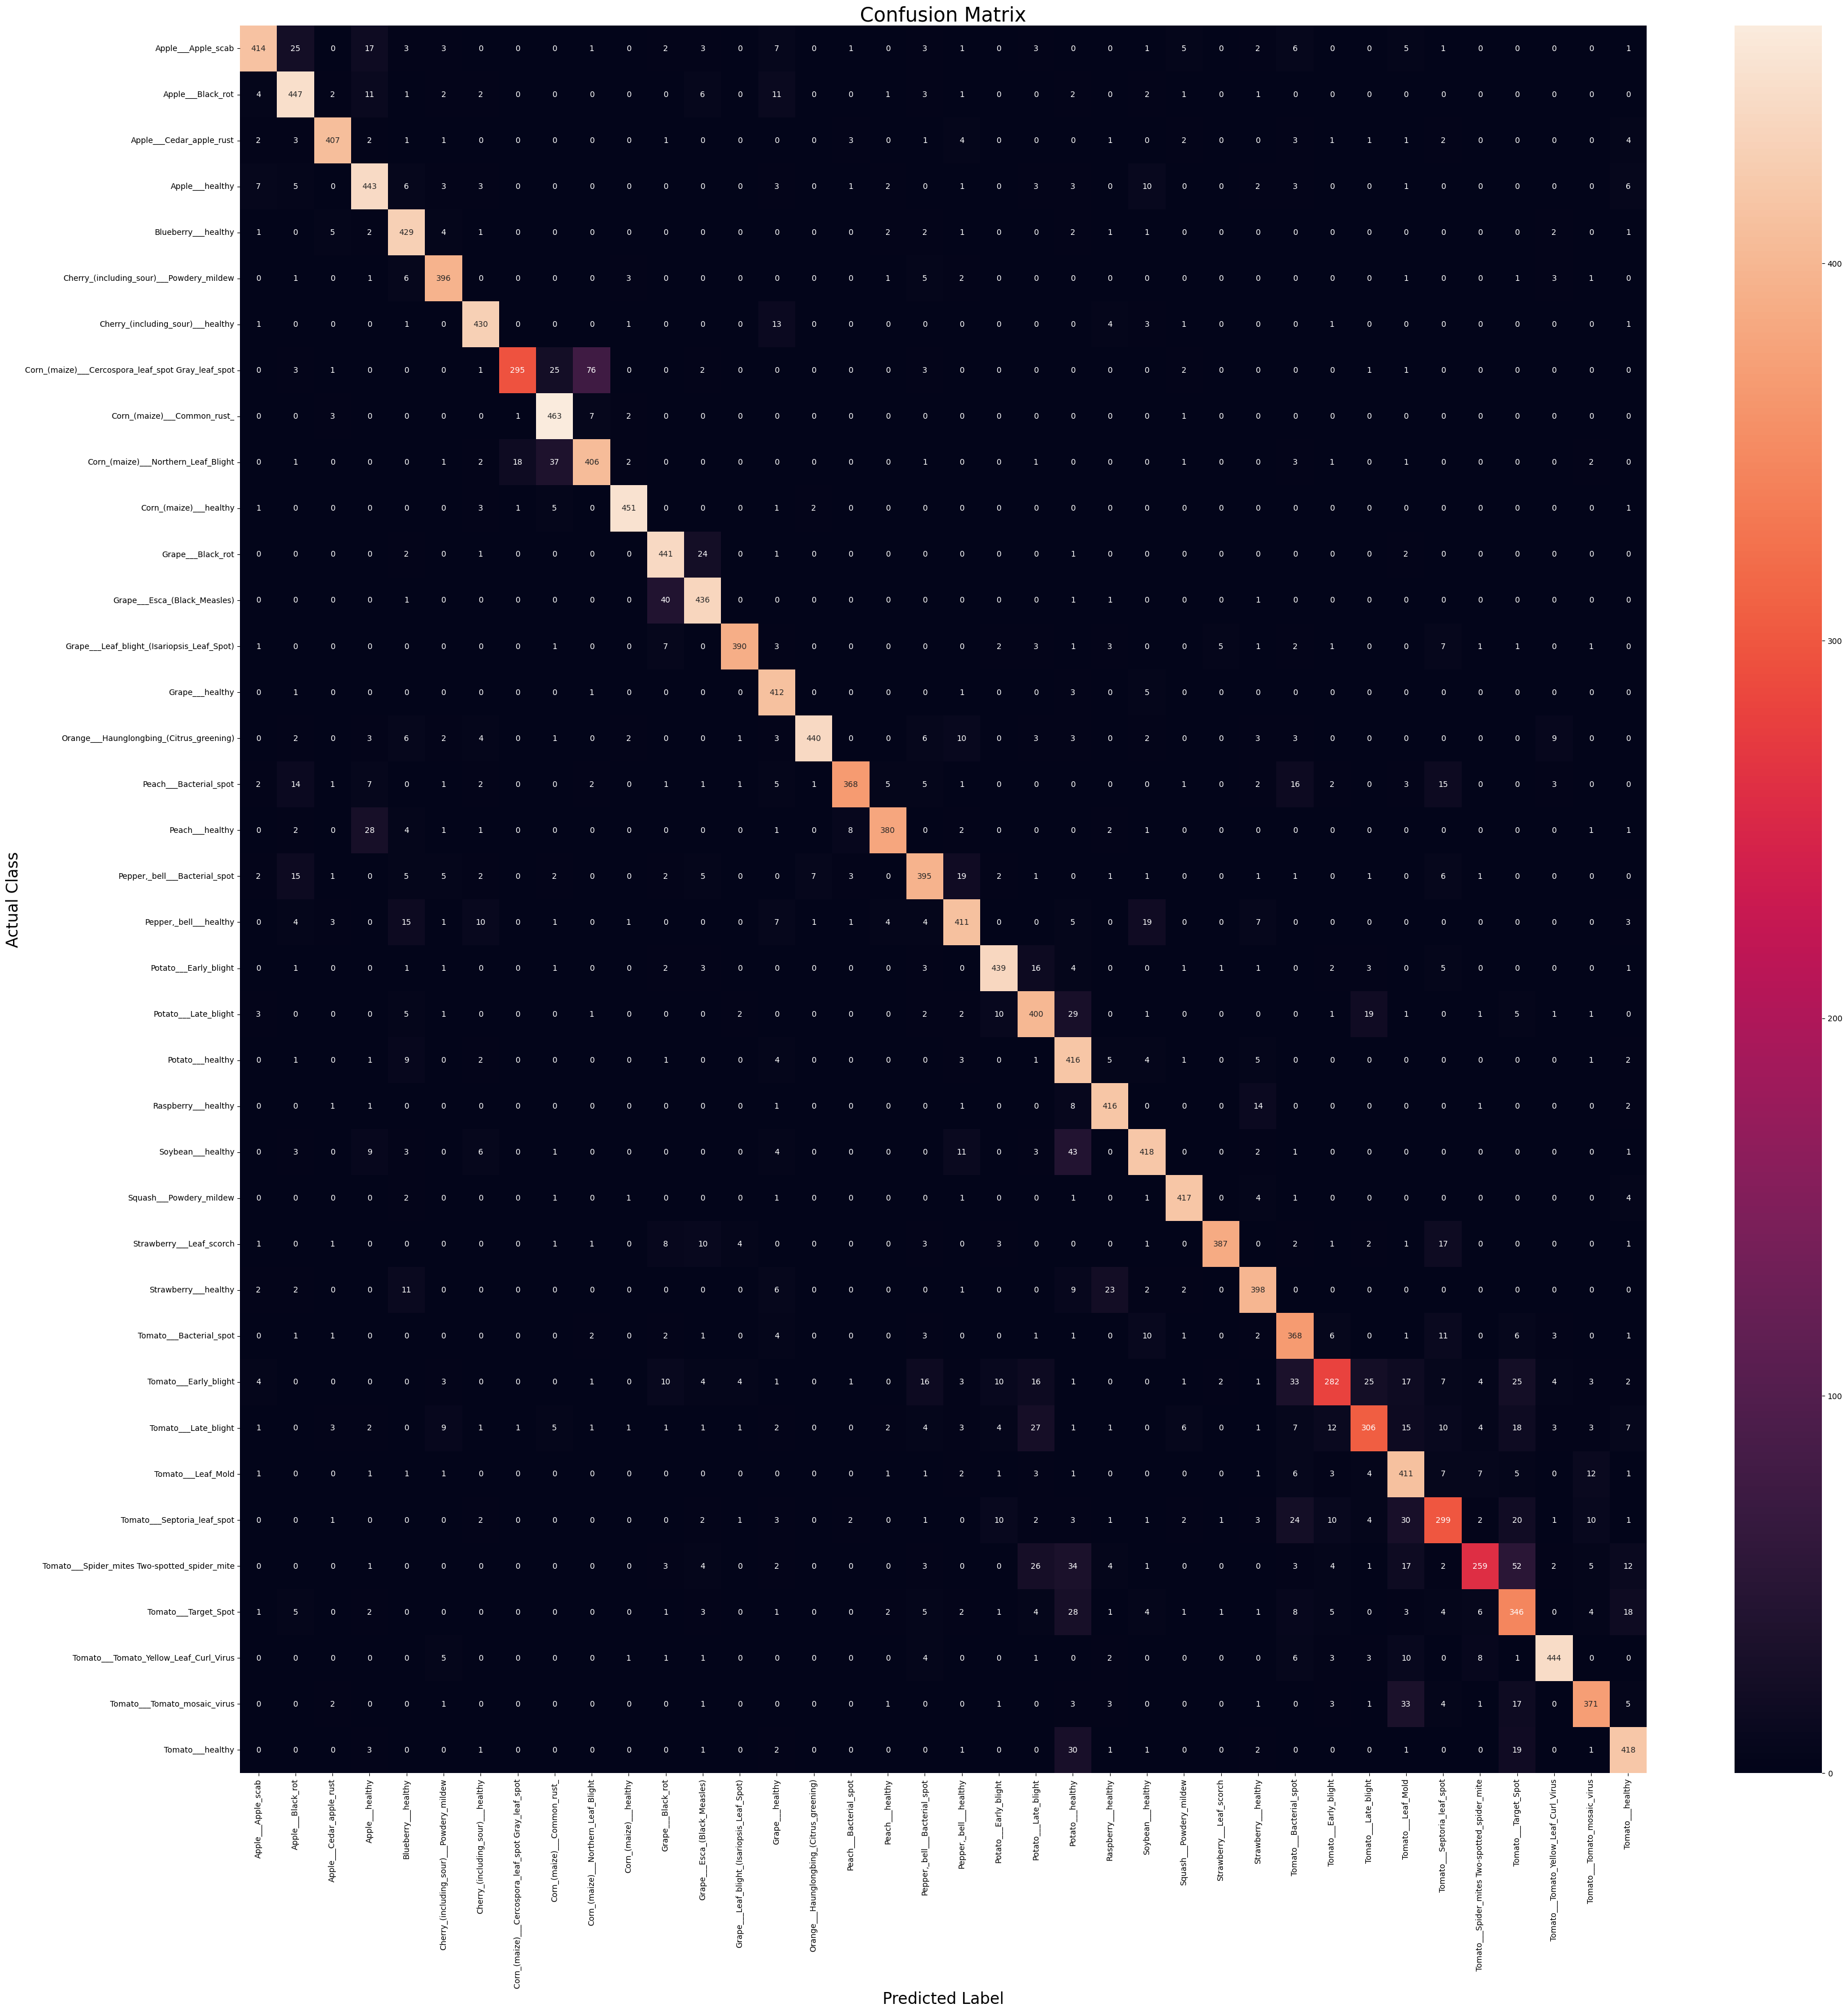

In [43]:
# Generate confusion matrix
cm = confusion_matrix(valid_labels, valid_preds, labels=range(len(class_names)))
plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 10}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.show()

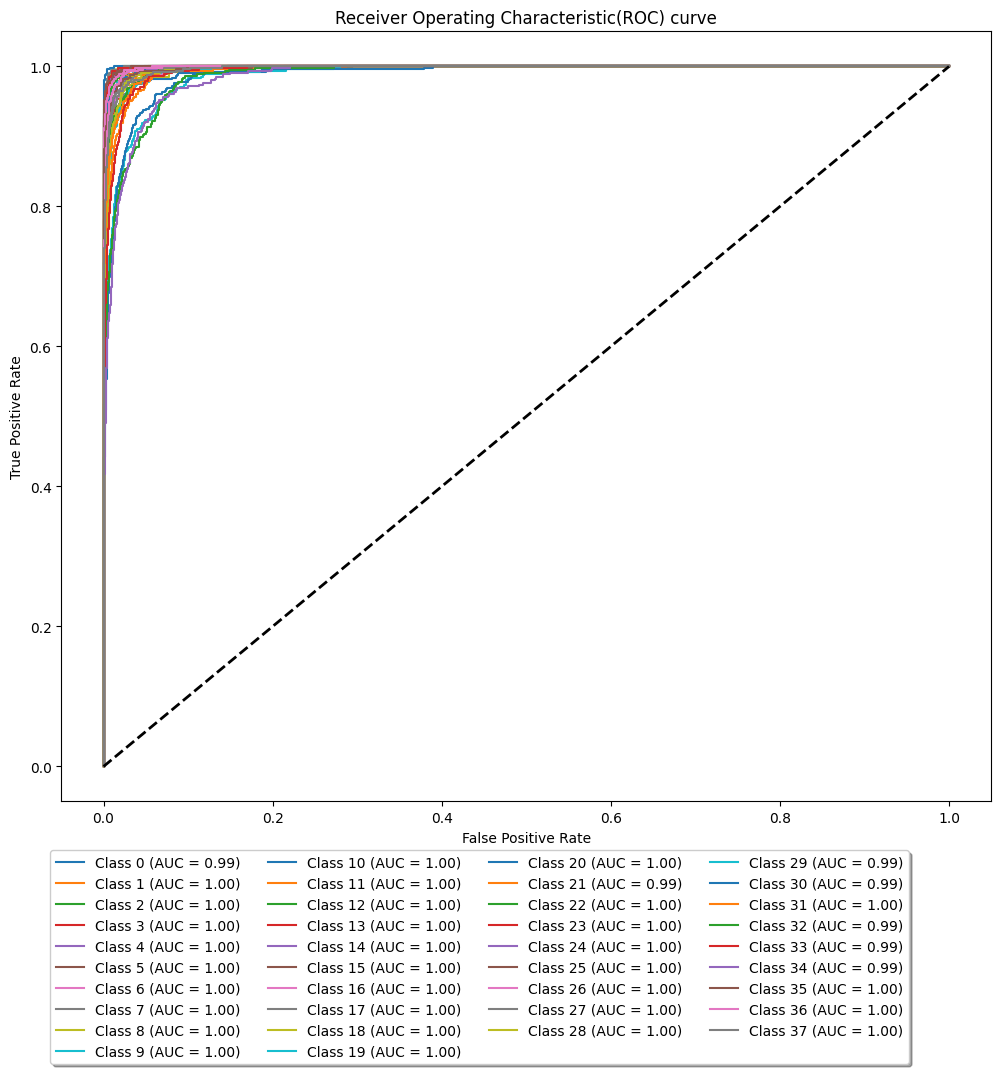

In [45]:
# Plot ROC curves
def plot_roc_curves(model, data_loader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
    
    # Binarize the labels
    y_true = label_binarize(all_labels, classes=range(num_classes))
    y_score = np.array(all_preds)
    
    # Compute ROC curves and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic(ROC) curve')
    plt.legend(loc='lower center', bbox_to_anchor=(0.45, -0.35), fancybox=True, shadow=True, ncol=4)
    plt.show()

plot_roc_curves(model, valid_loader, len(class_names))

### DenseNet

In [46]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [47]:

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)


In [48]:
# Define the DenseNet model
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, len(train_dataset.classes))

C:\Users\PREDATOR\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PREDATOR\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\PREDATOR/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|█████████████████████████████████████████████████████████████████████████████| 30.8M/30.8M [00:11<00:00, 2.77MB/s]


In [49]:
# Wrap model with DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [50]:

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Gradient accumulation settings
accumulation_steps = 4

# Train the model
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=1):
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch') as tepoch:
            for i, (images, labels) in enumerate(tepoch):
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss = loss / accumulation_steps  # Scale loss for gradient accumulation
                loss.backward()
                
                if (i + 1) % accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
                
                # Statistics
                running_loss += loss.item() * accumulation_steps
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar description
                tepoch.set_postfix(train_loss=running_loss / total, train_acc=correct / total)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(valid_loader)
        val_acc = val_correct / val_total
        
        # Save history
        history['train_loss'].append(epoch_loss)
        history['valid_loss'].append(val_loss)
        history['train_acc'].append(epoch_acc)
        history['valid_acc'].append(val_acc)
        
        # Print the full summary for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"train_acc: {epoch_acc:.4f}, train_loss: {epoch_loss:.4f}, "
              f"valid_loss: {val_loss:.4f}, valid_acc: {val_acc:.4f}")
    
    return history


In [51]:
# Train the model
history = train_model(model, train_loader, valid_loader, criterion, optimizer)


Epoch 1/1: 100%|████████████████████████████| 4394/4394 [17:26<00:00,  4.20batch/s, train_acc=0.842, train_loss=0.0412]


Epoch [1/1], train_acc: 0.8419, train_loss: 0.6598, valid_loss: 0.1768, valid_acc: 0.9466


In [52]:
# Save the model
torch.save(model.state_dict(), 'densenet.pth')
print("Model saved as densenet.pth")


Model saved as densenet.pth


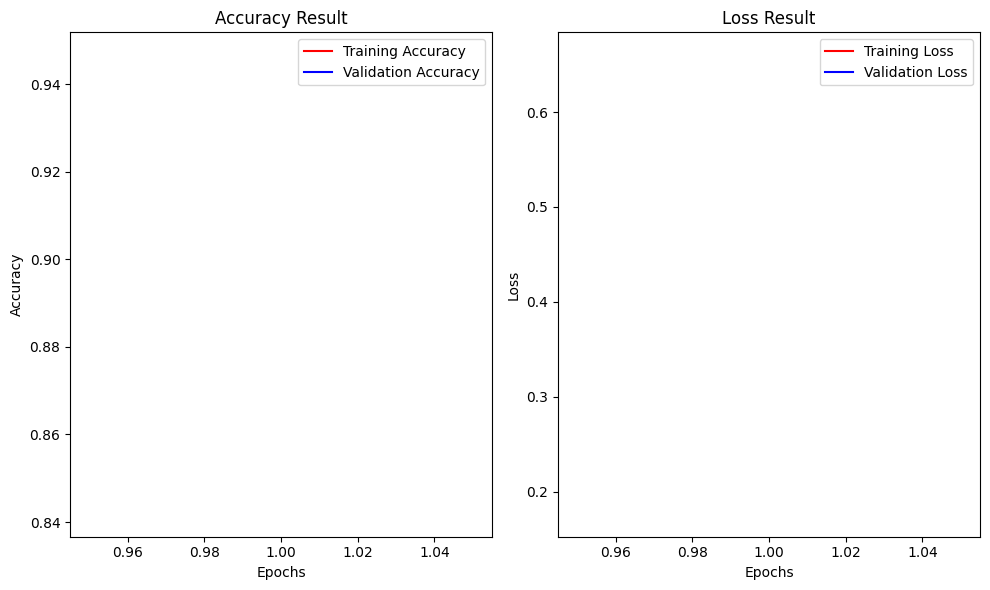

In [53]:
# Plotting results
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_acc'], 'r', label='Training Accuracy')
plt.plot(epochs, history['valid_acc'], 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Result')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'r', label='Training Loss')
plt.plot(epochs, history['valid_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Result')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:

# Evaluate the model
def evaluate(model, data_loader):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            
            # Collect all labels and predictions for classification report
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = corrects.double() / total
    
    return avg_loss, accuracy, all_labels, all_preds

# Evaluate on the training set
train_loss, train_acc, train_labels, train_preds = evaluate(model, train_loader)
print(f'Training Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}')

# Evaluate on the validation set
valid_loss, valid_acc, valid_labels, valid_preds = evaluate(model, valid_loader)
print(f'Validation Loss: {valid_loss:.4f} Accuracy: {valid_acc:.4f}')


Training Loss: 0.1667 Accuracy: 0.9501
Validation Loss: 0.1742 Accuracy: 0.9475


In [55]:
# Generate classification report for training set
class_names = train_dataset.classes
print("Training Set Classification Report:")
print(classification_report(train_labels, train_preds, target_names=class_names))


Training Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.94      0.96      2016
                                 Apple___Black_rot       0.97      0.97      0.97      1987
                          Apple___Cedar_apple_rust       0.98      0.97      0.98      1760
                                   Apple___healthy       0.96      0.96      0.96      2008
                               Blueberry___healthy       0.96      0.99      0.97      1816
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99      1683
                 Cherry_(including_sour)___healthy       0.97      0.99      0.98      1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.83      0.96      0.89      1642
                       Corn_(maize)___Common_rust_       0.97      0.99      0.98      1907
               Corn_(maize)___Northern_Leaf

In [56]:
# Generate classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(valid_labels, valid_preds, target_names=class_names))


Validation Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.96      0.97       504
                                 Apple___Black_rot       0.97      0.97      0.97       497
                          Apple___Cedar_apple_rust       0.98      0.98      0.98       440
                                   Apple___healthy       0.97      0.97      0.97       502
                               Blueberry___healthy       0.95      0.97      0.96       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       421
                 Cherry_(including_sour)___healthy       0.98      0.99      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.81      0.96      0.88       410
                       Corn_(maize)___Common_rust_       0.96      0.98      0.97       477
               Corn_(maize)___Northern_Le

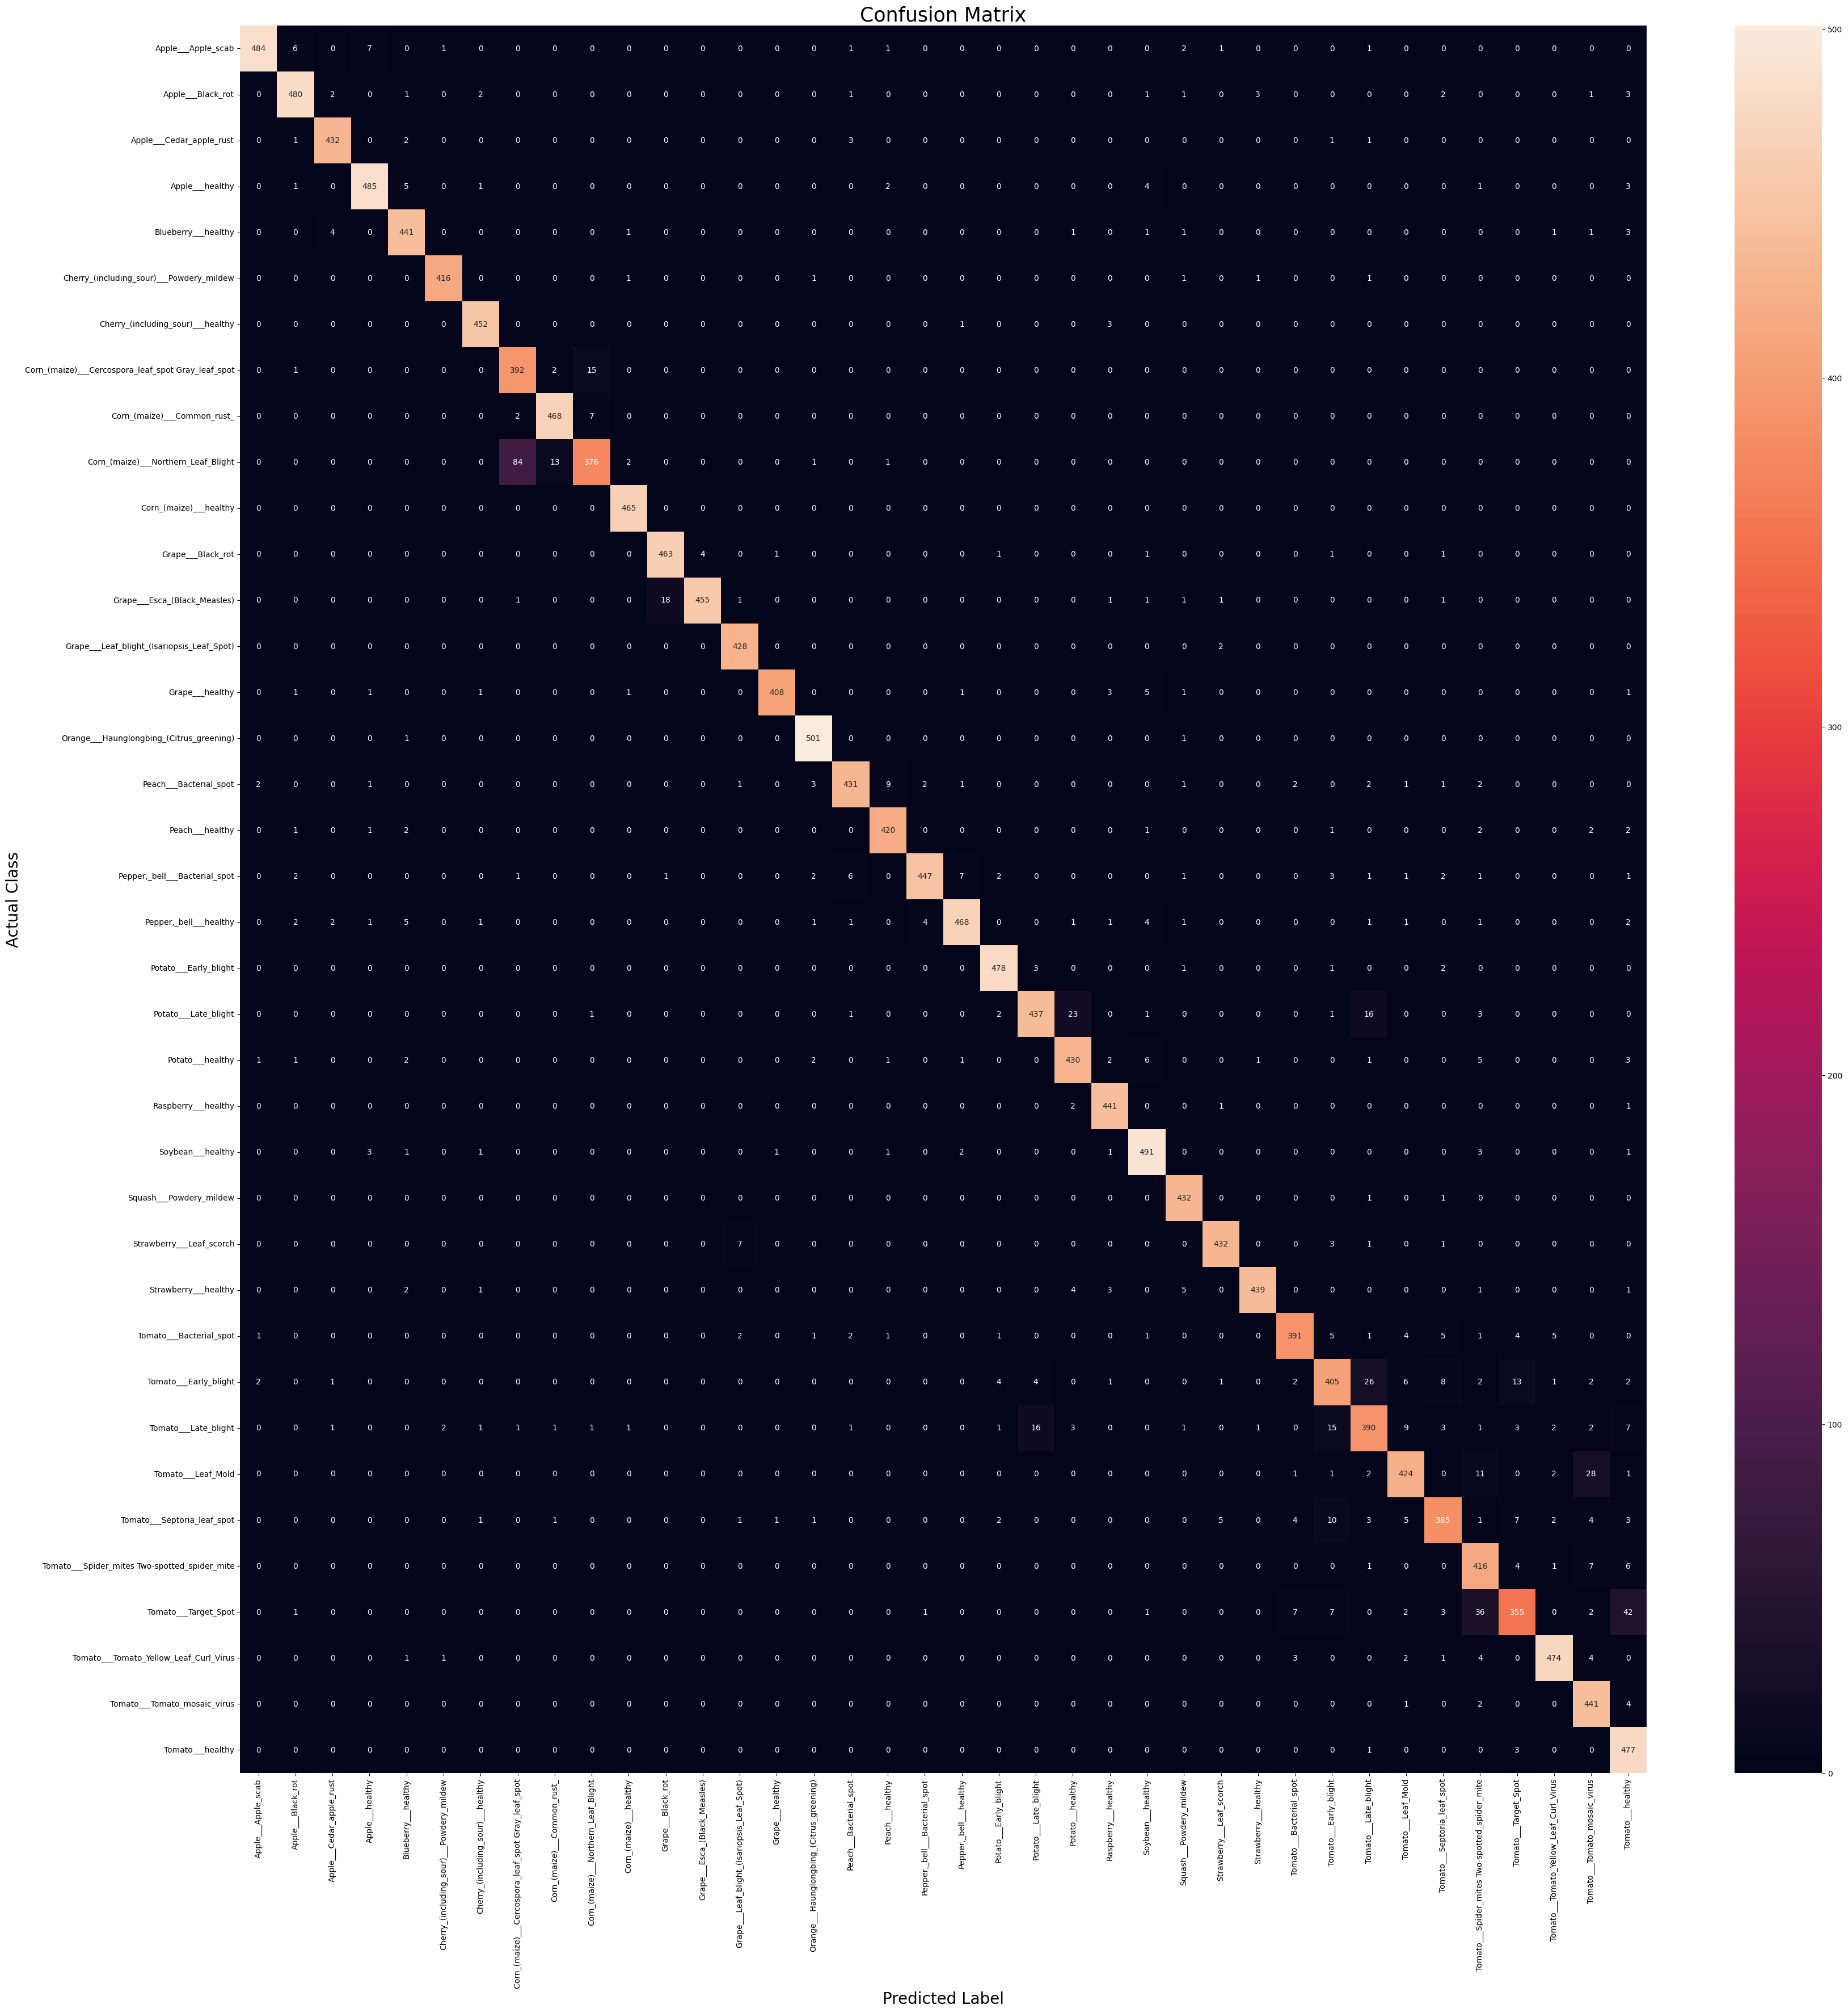

In [57]:
# Generate confusion matrix
cm = confusion_matrix(valid_labels, valid_preds, labels=range(len(class_names)))
plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 10}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.show()


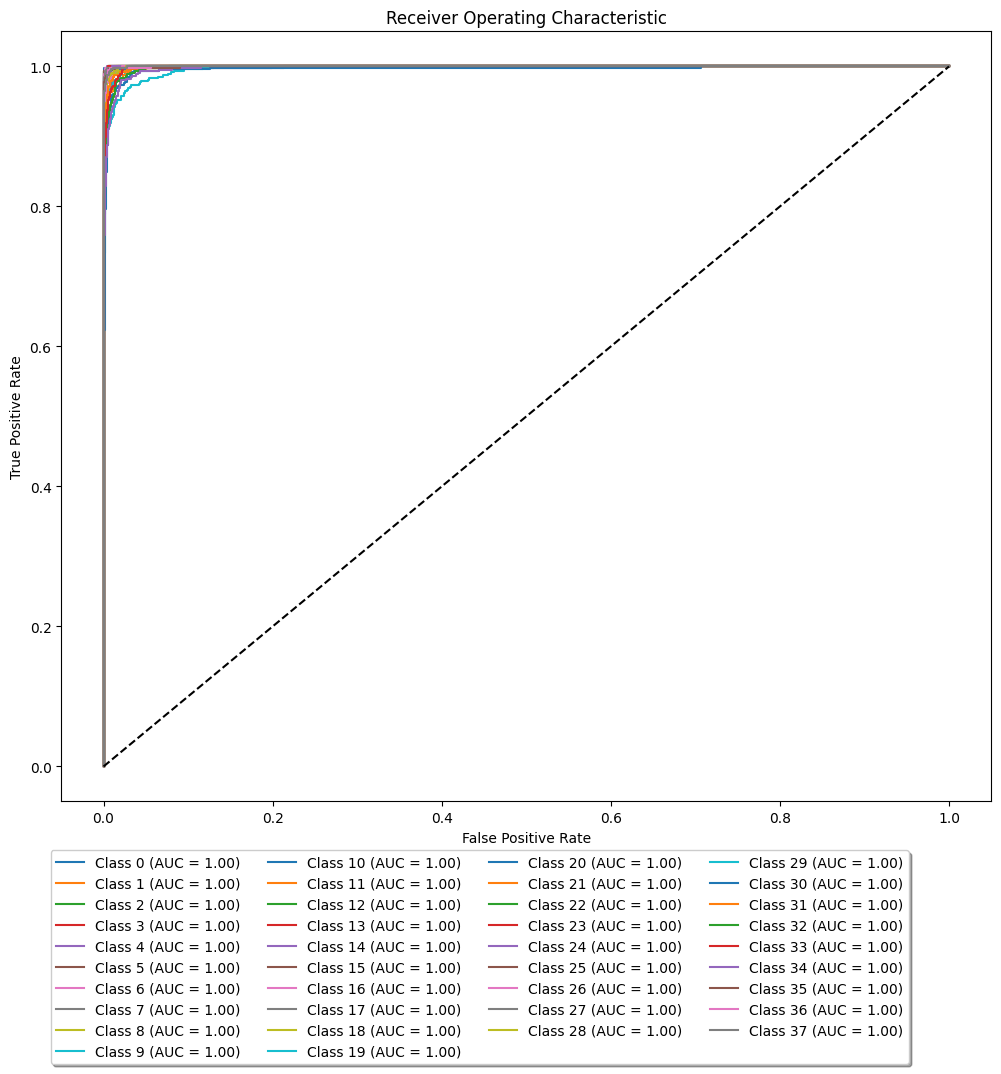

In [58]:
# Plot ROC curves
def plot_roc_curves(model, data_loader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
    
    # Binarize the labels
    y_true = label_binarize(all_labels, classes=range(num_classes))
    y_score = np.array(all_preds)
    
    # Compute ROC curves and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 10))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower center', bbox_to_anchor=(0.45, -0.35), fancybox=True, shadow=True, ncol=4)
    plt.show()

plot_roc_curves(model, valid_loader, len(class_names))

## Efficient Net

In [65]:
pip install efficientnet-pytorch

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16458 sha256=69d1e9838d91f494d7f0c8b093dfb8ee2e58bc8a1195f6cc32c6d1b941d9418f
  Stored in directory: c:\users\predator\appdata\local\pip\cache\wheels\9c\3f\43\e6271c7026fe08c185da2be23c98c8e87477d3db63f41f32ad
Successfully built efficientnet-pytorch
Note: you may need to restart the kernel to use updated packages.


In [62]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [63]:

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/train', transform=transform)
valid_dataset = datasets.ImageFolder(root='C:/Users/PREDATOR/Desktop/pldds/valid', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)


In [66]:
from efficientnet_pytorch import EfficientNet
# Define the EfficientNet model
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, len(train_dataset.classes))


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\PREDATOR/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|█████████████████████████████████████████████████████████████████████████████| 20.4M/20.4M [00:03<00:00, 5.38MB/s]

Loaded pretrained weights for efficientnet-b0


In [67]:
# Wrap model with DataParallel if more than one GPU is available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model.to(device)


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [68]:

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Gradient accumulation settings
accumulation_steps = 4

# Train the model
def train_model(model, train_loader, valid_loader, criterion, optimizer, num_epochs=1):
    history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit='batch') as tepoch:
            for i, (images, labels) in enumerate(tepoch):
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimization
                loss = loss / accumulation_steps  # Scale loss for gradient accumulation
                loss.backward()
                
                if (i + 1) % accumulation_steps == 0:
                    optimizer.step()
                    optimizer.zero_grad()
                
                # Statistics
                running_loss += loss.item() * accumulation_steps
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar description
                tepoch.set_postfix(train_loss=running_loss / total, train_acc=correct / total)
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        
        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(valid_loader)
        val_acc = val_correct / val_total
        
        # Save history
        history['train_loss'].append(epoch_loss)
        history['valid_loss'].append(val_loss)
        history['train_acc'].append(epoch_acc)
        history['valid_acc'].append(val_acc)
        
        # Print the full summary for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"train_acc: {epoch_acc:.4f}, train_loss: {epoch_loss:.4f}, "
              f"valid_loss: {val_loss:.4f}, valid_acc: {val_acc:.4f}")
    
    return history


In [69]:
# Train the model
history = train_model(model, train_loader, valid_loader, criterion, optimizer)


Epoch 1/1: 100%|█████████████████████████████| 4394/4394 [18:15<00:00,  4.01batch/s, train_acc=0.756, train_loss=0.061]


Epoch [1/1], train_acc: 0.7565, train_loss: 0.9755, valid_loss: 0.2038, valid_acc: 0.9355


In [70]:
# Save the model
torch.save(model.state_dict(), 'efficientnet.pth')
print("Model saved as efficientnet.pth")


Model saved as efficientnet.pth


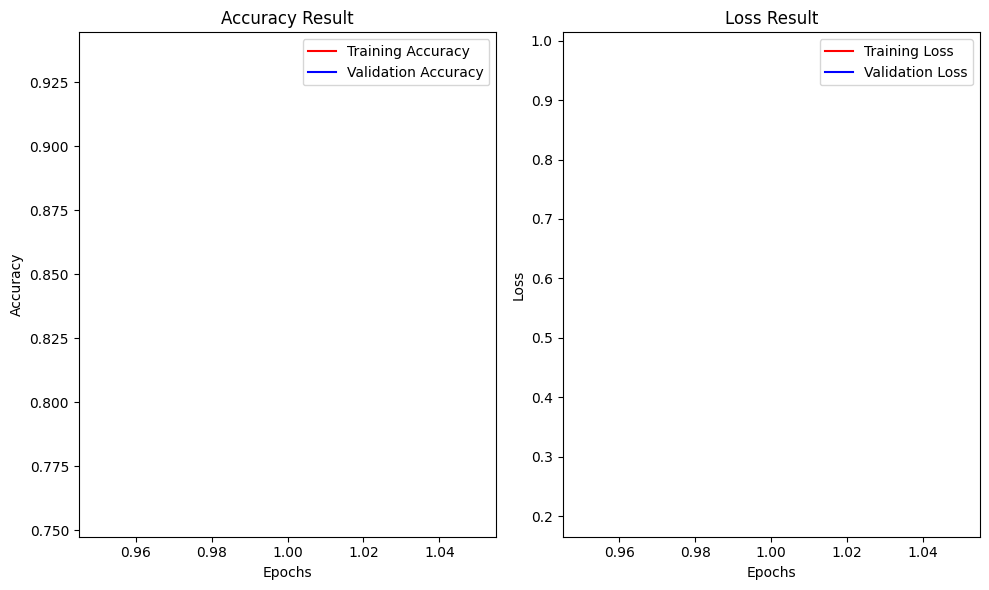

In [71]:
# Plotting results
epochs = range(1, len(history['train_loss']) + 1)
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_acc'], 'r', label='Training Accuracy')
plt.plot(epochs, history['valid_acc'], 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Result')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_loss'], 'r', label='Training Loss')
plt.plot(epochs, history['valid_loss'], 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Result')
plt.legend()

plt.tight_layout()
plt.show()


In [72]:
# Evaluate the model
def evaluate(model, data_loader):
    model.eval()
    running_loss = 0.0
    corrects = 0
    total = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            
            # Collect all labels and predictions for classification report
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader.dataset)
    accuracy = corrects.double() / total
    
    return avg_loss, accuracy, all_labels, all_preds

# Evaluate on the training set
train_loss, train_acc, train_labels, train_preds = evaluate(model, train_loader)
print(f'Training Loss: {train_loss:.4f} Accuracy: {train_acc:.4f}')

# Evaluate on the validation set
valid_loss, valid_acc, valid_labels, valid_preds = evaluate(model, valid_loader)
print(f'Validation Loss: {valid_loss:.4f} Accuracy: {valid_acc:.4f}')


Training Loss: 0.1933 Accuracy: 0.9403
Validation Loss: 0.2006 Accuracy: 0.9379


In [73]:
# Generate classification report for training set
class_names = train_dataset.classes
print("Training Set Classification Report:")
print(classification_report(train_labels, train_preds, target_names=class_names))


Training Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.93      0.95      2016
                                 Apple___Black_rot       0.97      0.95      0.96      1987
                          Apple___Cedar_apple_rust       0.97      0.95      0.96      1760
                                   Apple___healthy       0.96      0.93      0.94      2008
                               Blueberry___healthy       0.93      0.99      0.95      1816
          Cherry_(including_sour)___Powdery_mildew       0.98      0.98      0.98      1683
                 Cherry_(including_sour)___healthy       0.97      0.98      0.98      1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.91      0.92      0.92      1642
                       Corn_(maize)___Common_rust_       0.97      0.98      0.97      1907
               Corn_(maize)___Northern_Leaf

In [74]:
# Generate classification report for validation set
print("Validation Set Classification Report:")
print(classification_report(valid_labels, valid_preds, target_names=class_names))


Validation Set Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.92      0.94       504
                                 Apple___Black_rot       0.97      0.93      0.95       497
                          Apple___Cedar_apple_rust       0.98      0.95      0.96       440
                                   Apple___healthy       0.95      0.94      0.95       502
                               Blueberry___healthy       0.90      0.98      0.94       454
          Cherry_(including_sour)___Powdery_mildew       0.98      0.96      0.97       421
                 Cherry_(including_sour)___healthy       0.96      0.98      0.97       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.92      0.90      0.91       410
                       Corn_(maize)___Common_rust_       0.98      0.99      0.98       477
               Corn_(maize)___Northern_Le

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000025257A1E700>
Traceback (most recent call last):
  File "C:\Users\PREDATOR\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "C:\Users\PREDATOR\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


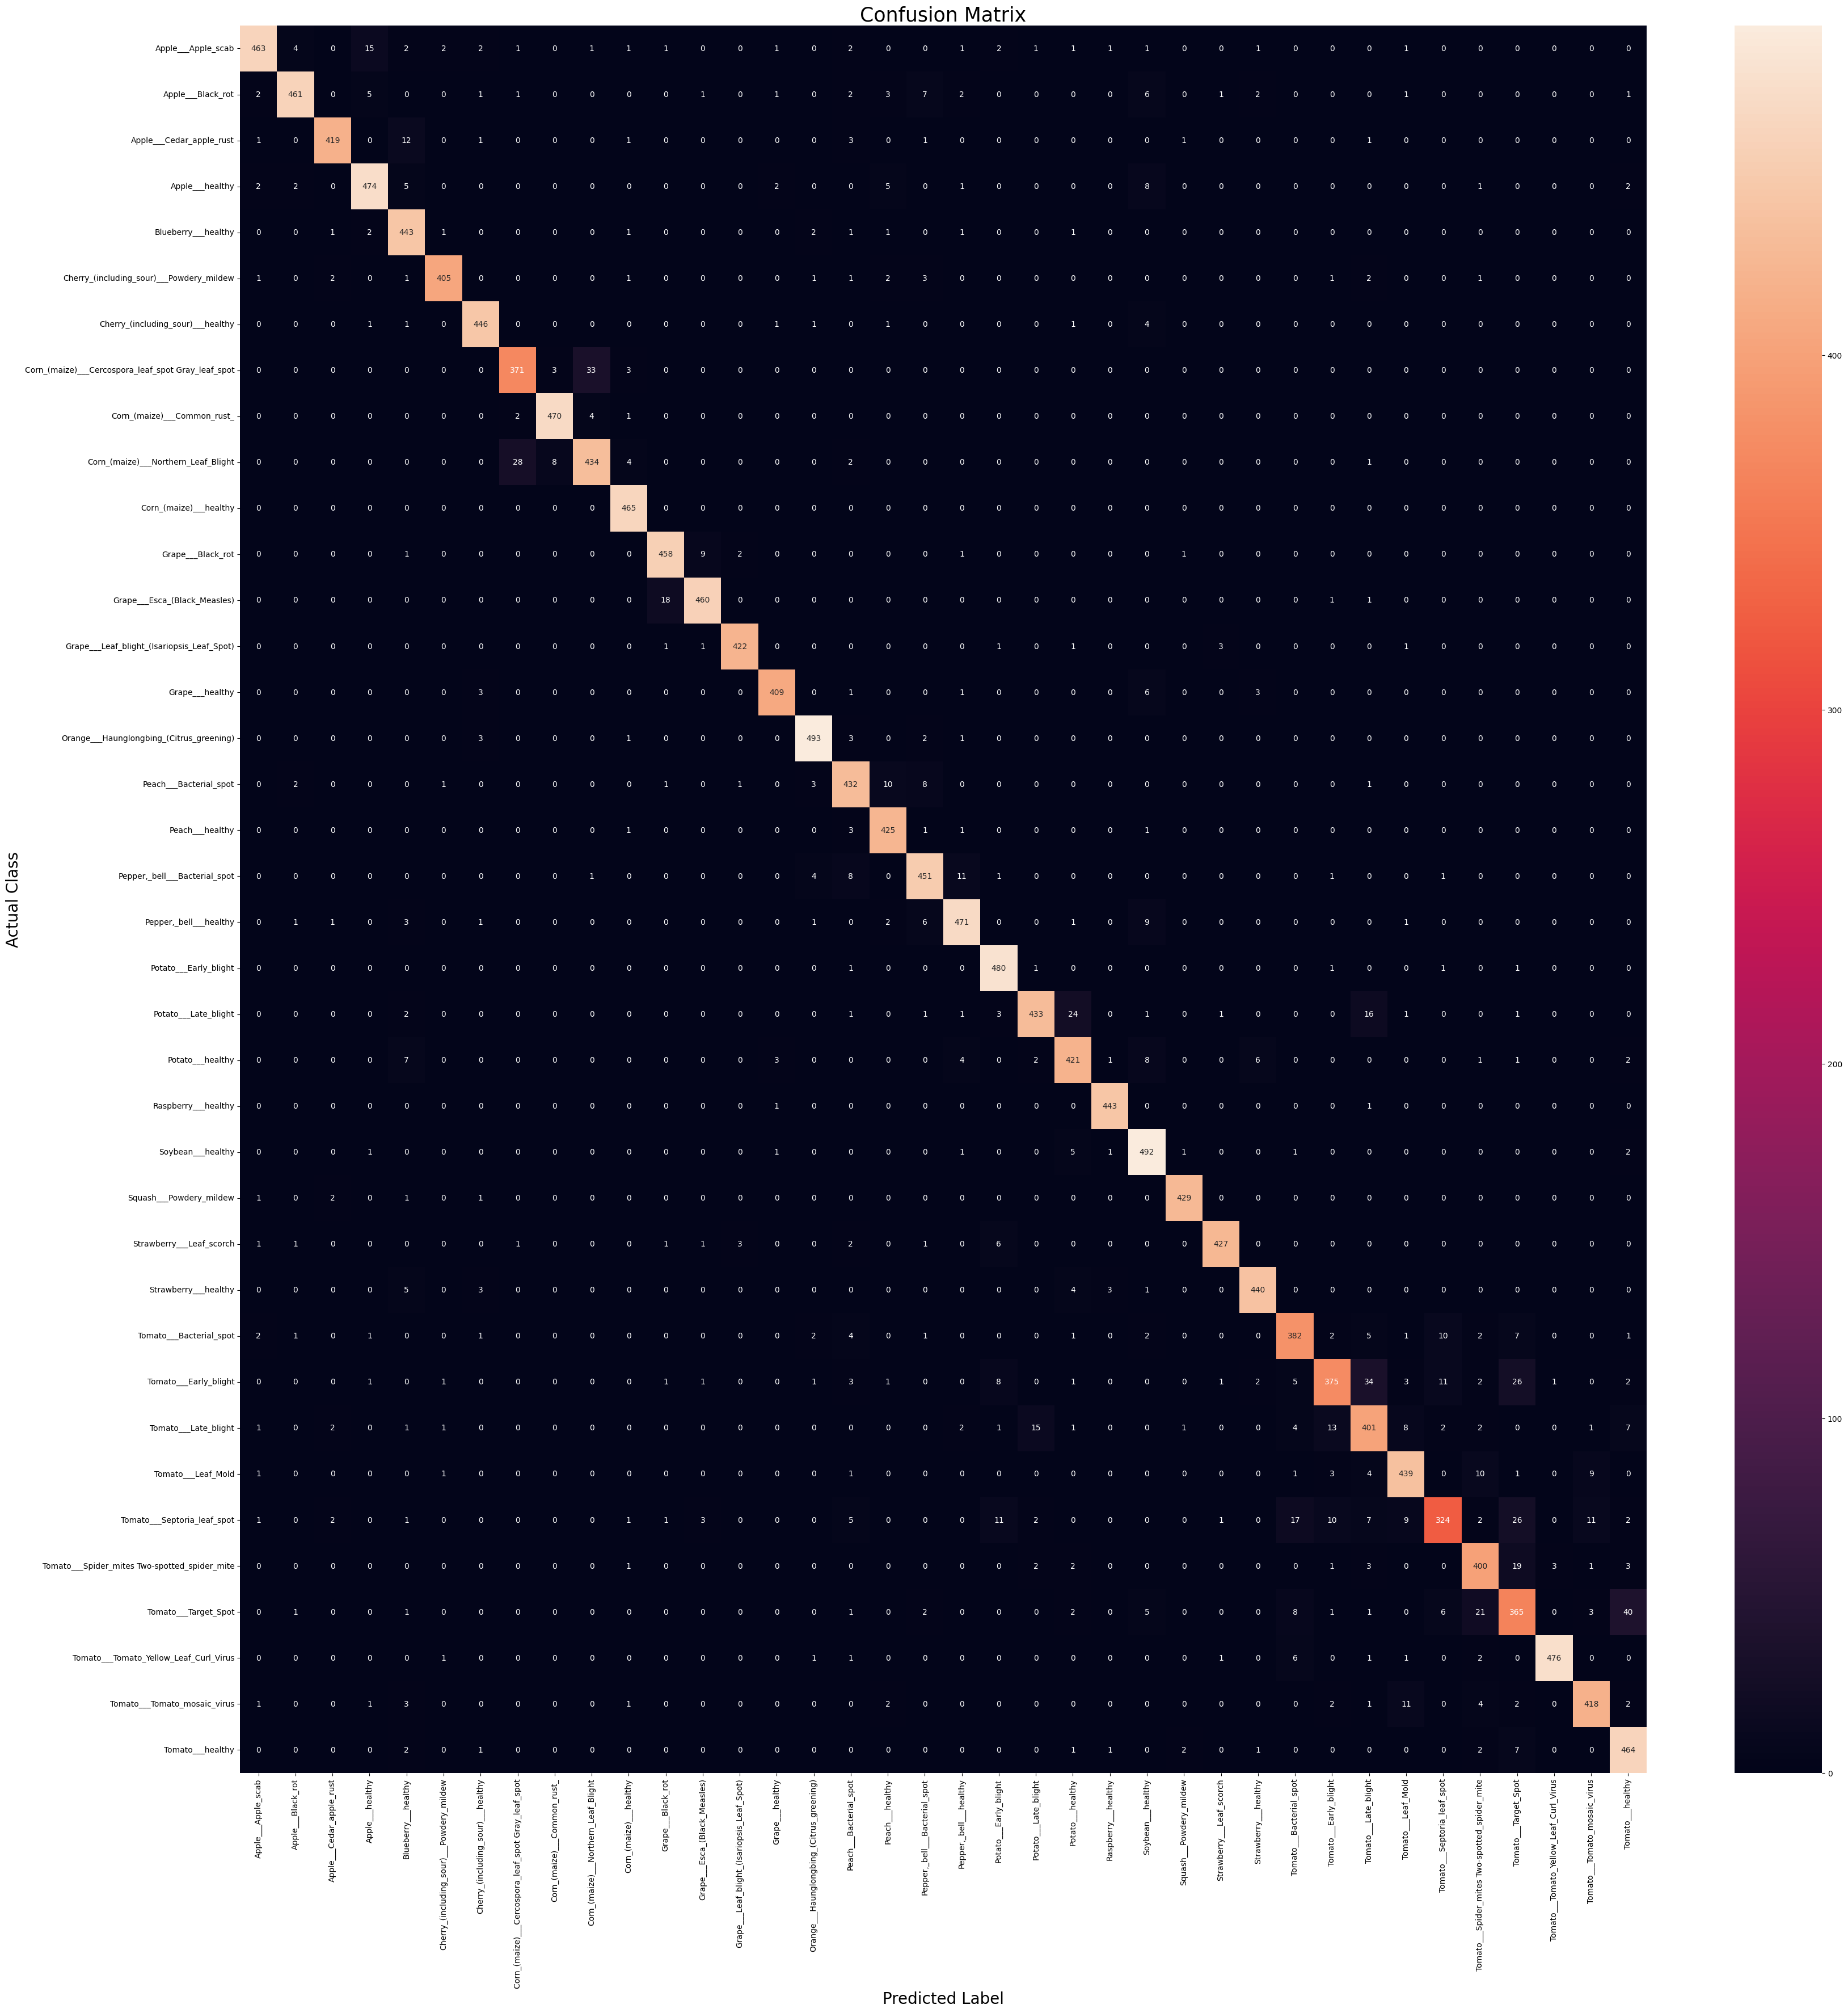

In [75]:

# Generate confusion matrix
cm = confusion_matrix(valid_labels, valid_preds, labels=range(len(class_names)))
plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 10}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel("Actual Class", fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.show()

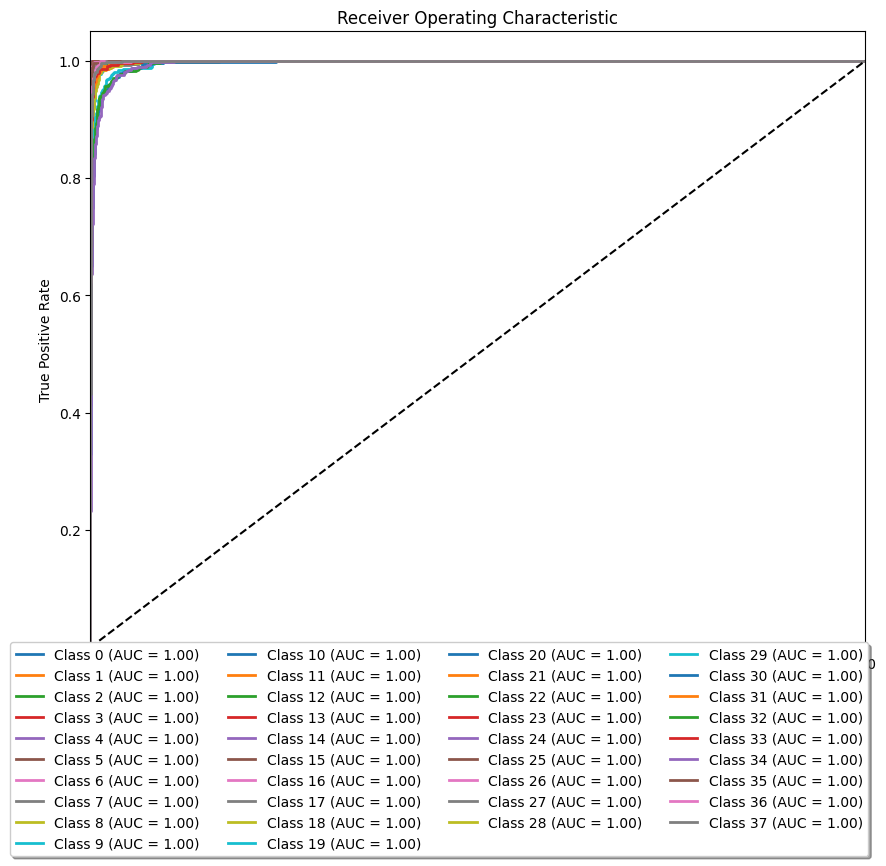

In [76]:

# Plot ROC curves
def plot_roc_curves(model, data_loader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            # Get probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
    
    # Binarize the labels
    y_true = label_binarize(all_labels, classes=range(num_classes))
    y_score = np.array(all_preds)
    
    # Compute ROC curves and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower center', bbox_to_anchor=(0.45, -0.35), fancybox=True, shadow=True, ncol=4) 
    plt.show()

plot_roc_curves(model, valid_loader, num_classes=len(class_names))